# Regulation as Elementary Phenomena
In the previous chapter, we demonstrated that the dynamic states of biochemical reaction networks can be characterized by elementary reactions. We now show how the phenomena of regulation can be described and simulated in the same framework by developing a simulation model of regulation of a prototypical biosynthetic pathway. The chemical reactions that underlie the regulatory steps are identified and their kinetic properties are estimated. These reactions are then added to the scaffold formed by the basic mass action kinetic description of the network of interest to simulate the effects of the regulation. This approach will then be applied to realistic situations in Part IV. 

**MASSpy** will be used to demonstrate some of the topics in this chapter.  

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction,
    Simulation, MassSolution, strip_time)
from mass.util.matrix import nullspace, left_nullspace
from mass.visualization import plot_time_profile, plot_phase_portrait

Other useful packages are also imported at this time.

In [2]:
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
XL_FONT = {"size": "x-large"}

## Regulation of Enzymes

Many factors regulate enzymes, their concentration, and their catalytic activity. We describe four different mechanisms here (Figure 9.1). 

* _Regulation of gene expression:_ the transcription of genes is regulated in an intricate way. Many proteins, called transcription factors, bind to the promoter region of a gene. Their binding can _induce_ or _repress_ gene expression. Metabolites often determine the active states of transcription factors. 

* _Interconversion:_ regulated enzymes can exist in many functional states. As we saw in Chapter 5, a regulatory enzyme can naturally exist in two conformations: catalytically-active and catalytically-inactive. Often, regulated enzymes are chemically modified through phosphorylation, methylation, or acylation to inter-convert them between inactive and active states. 

* _Binding by ligands:_ small molecules can bind to regulatory enzymes in an allosteric binding site (see Chapters 5 and 14). Such binding can promote the relaxed (R) or taught (T) state of the enzyme, leading to a 'tug of war' among its states. 

* _Cofactor and coenzyme availability:_ as detailed at the beginning of Chapter 8, enzymes rely on 'accessory molecules' for their function. Thus the availability of such molecules determines the functional state of the enzyme. 

* These are four genetic and biochemical mechanisms by which regulation of enzyme catalytic activity is exerted. We will now describe the dynamic consequences of such regulatory actions. We will focus on the binding of regulatory ligands, level 3 in Figure 9.1.

![Figure-9-1](../images/Ch9/Figure-9-1.png)

**Figure 9.1:** Four levels of regulation of enzymes: gene expression, interconversion, ligand binding, and cofactor availability. C1 and C2 represent a cofactor or a coenzyme and its two different states (charged and discharged).

## Unregulated Model
Before we begin examining the mechanisms of feedback inhibition, we will first look at an unregulated biosynthetic pathway that branches off a main pathway. In the main pathway, a metabolic intermediate, $x_1$, is being formed, and degraded as 

$$\begin{equation} \stackrel{b_1}{\rightarrow} x_1 \stackrel{v_0}{\rightarrow} \tag{9.1} \end{equation}$$

Then, an enzyme, $x_6$, can be convert $x_1$ to $x_2$ as

$$\begin{equation} x_1 + x_6 \stackrel{v_1}{\rightarrow} x_2 \tag{9.2} \end{equation}$$

that is followed by a series of reactions 

$$\begin{equation} x_2 \stackrel{v_2}{\rightarrow} x_6 + x_3 \stackrel{v_3}{\rightarrow} x_4 \stackrel{v_4}{\rightarrow} x_5 \stackrel{v_5}{\rightarrow} \tag{9.3} \end{equation}$$

to form $x_5$, that is an end product of a the biosynthetic pathway. This system represents a simple schema where a biosynthetic pathway branches off a main pathway, and it can be graphically illustrated as:

![Figure-9-2](../images/Ch9/Figure-9-2.png)

**Figure 9.2:** A schematic of a prototypical biosynthetic pathway that takes an intermediate of a main pathway $x_1$ and converts it into a product $x_5$ that is then used for other purposes such as biosynthesis.  Note that the convention for the boundary fluxes $(b_1,\ v_0,\ v_5)$ is to point into the system.  The fluxes through these reactions can be into the system (i.e. $b_1$) or out of the system $(v_0$ and $v_5)$ in this case.

### Define model

The model is constructed by defining the reactions involved and specifying the numerical values for the rate constants.

In [3]:
# Define model
unregulated = MassModel("Unregulated")

# Define metabolites
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
x4 = MassMetabolite("x4")
x5 = MassMetabolite("x5")
x6 = MassMetabolite("x6")

# Define reactions
b1 = MassReaction("b1", reversible=False)
b1.add_metabolites({x1: 1})

v0 = MassReaction("v0", reversible=False)
v0.add_metabolites({x1: -1})

v1 = MassReaction("v1", reversible=False)
v1.add_metabolites({x1: -1, x6: -1, x2: 1})

v2 = MassReaction("v2", reversible=False)
v2.add_metabolites({x2: -1, x3: 1, x6:1})

v3 = MassReaction("v3", reversible=False)
v3.add_metabolites({x3:-1, x4:1})

v4 = MassReaction("v4", reversible=False)
v4.add_metabolites({x4: -1, x5: 1})

v5 = MassReaction("v5", reversible=False)
v5.add_metabolites({x5: -1})

# Add reactions to model
unregulated.add_reactions([b1, v0, v1, v2, v3, v4, v5])

# Sort metabolites
unregulated.metabolites.sort()
unregulated.repair()

# Add the custom rate for b1
unregulated.add_custom_rate(b1, custom_rate=b1.kf_str)

Set parameter Username


### Null spaces and their content: unregulated model
We begin our analysis by looking at the contents of the two null spaces.  These are topological quantities that are condition independent.  In other words, these properties are always the same regardless of the numerical values of the parameters and the steady state.

The right null space has two pathways, one goes from the primary input $(b_1)$ and out of the biosynthetic pathway $(v_5)$ and one goes from the primary input $(b_1)$ and out of the primary pathway $(v_0)$. These two nulls space vectors correspond to the two pathways of this system.

In [4]:
# Obtain nullspace
ns = nullspace(unregulated.S)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])
    
# Row operations to find meaningful pathways
ns[1] = (ns[0] + 2*ns[1])/7
ns[0] = (ns[0] - ns[1])/2
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in unregulated.reactions],
             columns=["Path 1", "Path 2"], dtype=np.int64)

,Path 1,Path 2
b1,1,1
v0,0,1
v1,1,0
v2,1,0
v3,1,0
v4,1,0
v5,1,0


We can visualize the two pathway vectors on the network map as shown in Figure 9.3.

![Figure-9-3](../images/Ch9/Figure-9-3.png)

**Figure 9.3:** The two pathways of the of the system under consideration correspond to the two vectors that span the null space of $\textbf{S}$. One pathway (a) goes from the primary input and out of the biosynthetic pathway while the other (b) goes in the primary input and out of the primary pathway.

The left null space has one pool: the conservation of the enzyme that is found in the active form $(x_6)$ or in the intermediary complex $(x_2)$. We can compute the left null space vector and form the conserved pool. Notice that the initial conditions that are used for simulation will fix the size of this pool.

In [5]:
# Obtain left nullspace
lns = left_nullspace(unregulated.S)
# Iterate through left nullspace and divide by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(row[np.nonzero(row)])
    lns[i] = np.array(row/minval)
    # Ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in lns[i]])

#Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, columns=unregulated.metabolites, 
             index=["Total Enzyme"], dtype=np.int64)

,x1,x2,x3,x4,x5,x6
Total Enzyme,0,1,0,0,0,1


### Steady state: unregulated model
We now evaluate the steady state by simulating the system to very long times. We will set the total enzyme concentration to 1 by specifying $x_6 = 1$ and all other concentrations as 0 at the initial time.  The flux into the system $(b_1)$ is given by $k_{b_{1}}^\rightarrow$  of 0.1; a zeroth order reaction, that is, it is a constant and does not respond to any of the state variables (the concentrations) of the system.

In [6]:
# Define parameters
b1.kf = 0.1
v0.kf = 0.5
v1.kf = 1
v2.kf = 1
v3.kf = 1
v4.kf = 1
v5.kf = 1

# Define initial conditions
unregulated.update_initial_conditions(
    dict((met, 0) if met.id != "x6"
         else (met, 1) for met in unregulated.metabolites))

We simulate the model to obtain the concentration and flux solutions, then we plot the time profile of the concentrations and the fluxes.  

In [7]:
(t0, tf) = (0, 1e4)
sim_unreg = Simulation(unregulated, id="Enzyme_Regulation", verbose=True)
conc_sol, flux_sol = sim_unreg.simulate(
    unregulated, time=(t0, tf), 
    interpolate=True, verbose=True)

# Place models and simulations into lists for later
models = [unregulated]
simulations = [sim_unreg]

Successfully loaded MassModel 'Unregulated' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Unregulated'
Simulating 'Unregulated'
Simulation for 'Unregulated' successful
Adding 'Unregulated' simulation solutions to output
Updating stored solutions


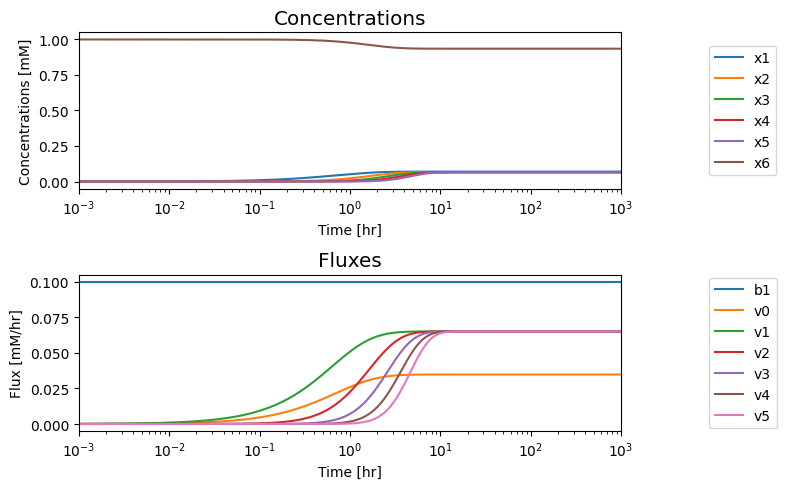

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), )
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-3, 1e3),
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-3, 1e3),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Fluxes", XL_FONT));
fig.tight_layout()

We can call out the values as particular time points if we like.

In [9]:
time_points = [1e0, 1e1, 1e2, 1e3]
# Make a pandas DataFrame using a dictionary and generators
pd.DataFrame({rxn: [round(value, 3) for value in flux_func(time_points)]
              for rxn, flux_func in flux_sol.items()}, 
             index=["t=%i" % t for t in time_points])

,b1,v0,v1,v2,v3,v4,v5
t=1,0.1,0.026,0.051,0.023,0.007,0.002,0.000
t=10,0.1,0.035,0.065,0.065,0.065,0.065,0.064
t=100,0.1,0.035,0.065,0.065,0.065,0.065,0.065
t=1000,0.1,0.035,0.065,0.065,0.065,0.065,0.065


We note that in the eventual steady state that all the fluxes in the biosynthetic pathway are equal, and that the overall flux balance on inputs and outputs, that is $b_1 = v_0 + v_5$, holds. 

**A numerical QC/QA**: Check the size of the enzyme pool at various time points:

In [10]:
conc_sol.make_aggregate_solution(
    "Total_Enzyme", equation="x2 + x6", variables=["x2", "x6"]);

pd.DataFrame({
    "Total Enzyme": conc_sol["Total_Enzyme"](time_points)},
    index=["t=%i" % t for t in time_points]).T

,t=1,t=10,t=100,t=1000
Total Enzyme,1.0,1.0,1.0,1.0


We can compute the steady state concentrations and replace the initial conditions of the model with those steady state concentrations. This will put the system into a steady state from which we can perturb the system. We will look at perturbations in the input flux $b_1$.

In [11]:
unregulated_ss = sim_unreg.find_steady_state(
    unregulated, strategy="simulate", update_values=True,
    verbose=True)

Setting output selections
Setting simulation values for 'Unregulated'
Setting output selections
Getting time points
Simulating 'Unregulated'
Found steady state for 'Unregulated'.
Updating 'Unregulated' values
Adding 'Unregulated' simulation solutions to output


### Dynamic states: unregulated model
#### Simulate the response to a step change in the input $b_1$  by 10-fold
We will now perform dynamic simulation by simulating the response to a 10-fold change in the input flux $b_1$. This perturbation will create a strong dynamic response, after which the systems settles down in a new steady state. In a separate plot we will focus on $v_1$ and $v_5$ as the inputs and outputs to the biosynthetic pathway that we will trying to regulate below. 

In [12]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 50)
conc_sol, flux_sol = sim_unreg.simulate(
    unregulated, time=(t0, tf),
    perturbations=perturbation_dict)

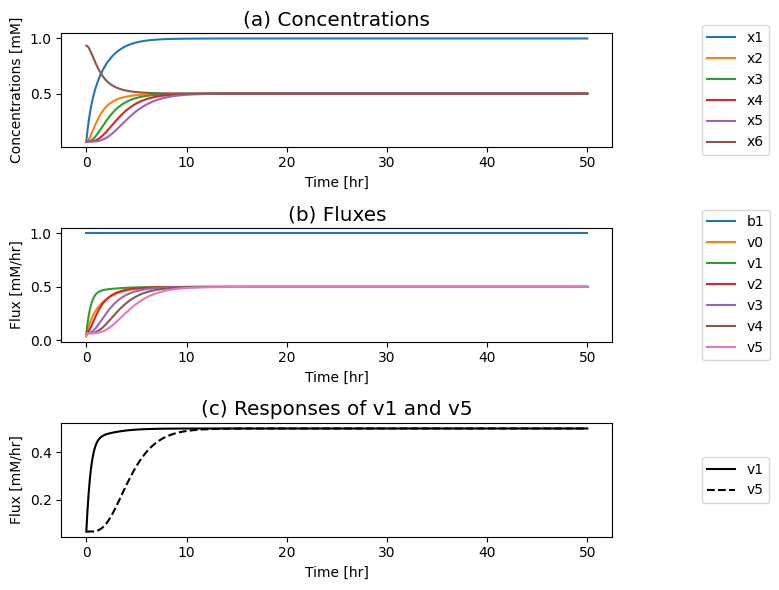

In [13]:
fig_9_4, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("(a) Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(b) Fluxes", XL_FONT));

plot_time_profile(
    flux_sol, observable=["v1", "v5"], ax=ax3, 
    legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(c) Responses of v1 and v5", XL_FONT),
    color="black", linestyle=["-", "--"]);
fig_9_4.tight_layout()

**Figure 9.4:** The time profiles for the concentrations and fluxes involved in the simple feedback control loop without the regulatory mechanism. The parameter values used are $k_0 = 0.5$, $k_1 = k_2 = k_3 = k_4 = k_5 = 1$, and $e_t = 1$. Just prior to time zero, the input rate is $b_1 = 0.1$, and the model is at steady state where $x_1 = 0.0697$, $x_2 = x_3 = x_4 = x_5 = 0.0652$, $x_6 = 0.935$. The input rate is changed to a specified number at time zero and the dynamic response is simulated. (a) The concentrations as a function of time. (b) The reaction fluxes as a function of time. (c) Dynamic response of $v_1$ and $v_5$ to the perturbation.

#### Seeking a graphical representation to understand the solution better
We introduce two useful phase portraits.  First we notice that $v_1$ and $v_5$ have to be equal in a steady state, that is the input and output of the biosynthetic pathway have to be equal.  If we plot them on a phase portrait, we see that the initial and final points have to be on the 45 degree line where the two fluxes are equal. We also see that the final state after the perturbation lies far away from the initial state.  The dynamics are such that the flux through the first step in the pathway $v_1$ changes first creating a horizontal motion, that is followed by a change in the output flux, $v_5$, creating a vertical motion to the 45 degree line where the system settles down.  We notice that a lot of the additional incoming flux through $b_1$ goes down the biosynthetic pathway. Below we will study how regulation can diminish the flux through the biosynthetic pathway.

Second, we know that the overall flux balance on inputs and outputs, that is $b_1 = v_0 + v_5$, hold at the starting point and final point.  These will be represented by lines of negative slop of 45 degrees in a phase portrait formed by $v_0$ and $v_5$ since there sum is a constant.  This line is given by $v_5 = b_1 - v_0$.  These lines corresponding to the initial flux and perturbed flux through $b_1$ can be graphed.  The initial and final states must be on these two lines.

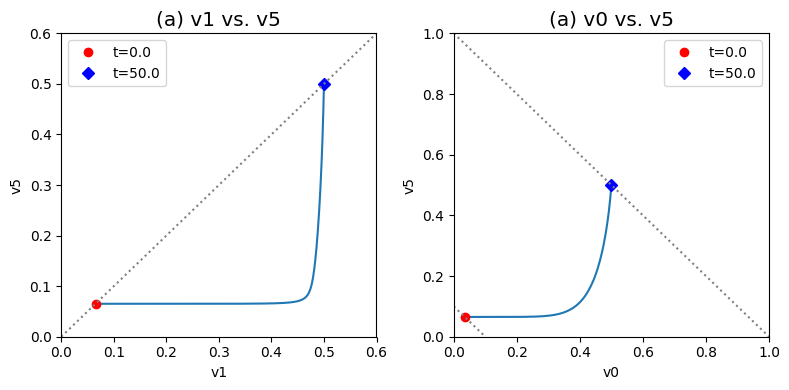

In [14]:
fig_9_5, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
(ax1, ax2) = axes.flatten()


# Plot v1 vs. v5
plot_phase_portrait(
    flux_sol, x="v1", y="v5", ax=ax1,
    xlim=(0, 0.6), ylim=(0, 0.6),
    xlabel="v1", ylabel="v5",
    title=("(a) v1 vs. v5", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_legend="best");

# Plot v0 vs. v5
plot_phase_portrait(
    flux_sol, x="v0", y="v5", ax=ax2,
    legend=([unregulated.id], "right outside"),
    xlim=(0, 1), ylim=(0, 1),
    xlabel="v0", ylabel="v5", 
    title=("(a) v0 vs. v5", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_legend="best");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_5.tight_layout()

**Figure 9.5:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5).$ The model is the same as in Figure 9.4. The red points are at the start time and the blue points are at the final time.

#### Breaking down the steady states into the pathway vectors
We can study the steady state solutions by breaking them down into a linear combination of the two pathway vectors in the null space.  These two vectors span the null space and can be used to represent any given valid steady state solution. We can tabulate the two pathway vectors and the initial and final flux states as; 

In [15]:
unregulated_ss_perturbed = sim_unreg.find_steady_state(
    unregulated, strategy="simulate",
    perturbations=perturbation_dict)

unperturbed = [round(value,3) for value in unregulated_ss[1].values()]
perturbed = [round(value,3) for value in unregulated_ss_perturbed[1].values()]

pd.DataFrame(np.vstack((ns.T, unperturbed, perturbed)), 
             index=["Nullspace Path 1", "Nullspace Path 2", "Unperturbed fluxes", "Perturbed fluxes"], 
             columns=[rxn.id for rxn in unregulated.reactions],
             dtype=np.float64)

,b1,v0,v1,v2,v3,v4,v5
Nullspace Path 1,1.0,0.000,1.000,1.000,1.000,1.000,1.000
Nullspace Path 2,1.0,1.000,0.000,0.000,0.000,0.000,0.000
Unperturbed fluxes,0.1,0.035,0.065,0.065,0.065,0.065,0.065
Perturbed fluxes,1.0,0.500,0.500,0.500,0.500,0.500,0.500


The overall flux balance is $b_1 = v_0 + v_5$. Thus, the first pathway goes from 35% of $b_1$ to 50% of $b_1$ after the perturbation and the second pathway goes from a 65% of $b_1$ to 50% of $b_1$ after the perturbation. 

**A numerical QC/QA:** The loadings on $v_0$ and $v_5$ should add up to $b_1$: 

In [16]:
before = unregulated_ss[1]["v0"] +\
         unregulated_ss[1]["v5"] == unregulated_ss[1]["b1"]
after = unregulated_ss_perturbed[1]["v0"] +\
        unregulated_ss_perturbed[1]["v5"] == unregulated_ss_perturbed[1]["b1"]

pd.DataFrame([before, after],
             index=["Before Perturbation", "After Perturbation"],
             columns=["Add up to b1?"])

,Add up to b1?
Before Perturbation,False
After Perturbation,True


## Regulated Model: Feedback Inhibition of a Pathway   
In this section we study the mechanisms of feedback inhibition by the end product of the biosynthetic pathway on the first reaction in the pathway. We can use simulation and case studies to determine the effectiveness of the regulatory action. We will use elementary reactions to describe the regulatory mechanism. 

### Feedback regulation in a biosynthetic pathway  
In a biosynthetic pathway, the first reaction is often inhibited by binding of the end product of the pathway to the regulated enzyme. The end product, $x_5$, feedback inhibits the enzyme, $x_6$, by binding to it and converting it into an inactive form: 

$$\begin{equation} x_6 + x_5 \underset{v_{-6}}{\stackrel{v_6}{\rightleftharpoons}} x_7 \tag{9.4} \end{equation}$$

This regulation represents a simple negative feedback loop. It can be added into the schematic of the system, resulting in Figure 9.6. 

![Figure-9-6](../images/Ch9/Figure-9-6.png)

**Figure 9.6:** A schematic of a prototypical feedback loop for a biosynthetic pathway. The end product of the pathway, $x_5$, feedback inhibits the flux into the pathway by binding to the enzyme catalyzing the first reaction of the pathway.

### Expand model
The model is expanded by defining the binding and conversion of the enzyme, $x_6$, to its inactive form and specifying the numerical values for the rate constants.

In [17]:
# Copy the unregulated model
monomer = unregulated.copy()
# Change the model ID
monomer.id = "Monomer"

# Define new metabolite 
x7 = MassMetabolite("x7")
mets = monomer.metabolites

# Define new reaction and set parameters
v6 = MassReaction("v6"); 
v6.add_metabolites({mets.x5: -1, mets.x6: -1, x7:1})
v6.get_mass_action_rate(rate_type=2, update_reaction=True)
# Add Reaction to the model
monomer.add_reactions([v6])
monomer.update_S(array_type="DataFrame");

### Null spaces and their content: regulated model
When we look at the right null space, we observe that the addition of the inhibition step did not change the pathway vectors, meaning that $v_6$ is a dead-end reaction and is not found in any pathway as it carries no flux in a steady state; it is at equilibrium in the steady state.

In [18]:
# Obtain nullspace
ns = nullspace(monomer.S, rtol=1e-10)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

# Find the viable pathways using linear combinations of the nullspace
ns[1] = (ns[0] + 2*ns[1])/7
ns[0] = (ns[0] - ns[1])/2

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in monomer.reactions],
             columns=["Path 1", "Path 2"], dtype=np.int64)

,Path 1,Path 2
b1,1,1
v0,0,1
v1,1,0
v2,1,0
v3,1,0
v4,1,0
v5,1,0
v6,0,0


![Figure-9-7](../images/Ch9/Figure-9-7.png)

**Figure 9.7:** The two pathways of a prototypical negative feedback loop for the biosynthetic pathway. As for the unregulated system, one pathway (a) goes from the primary input and out of the biosynthetic pathway while the other (b) goes in the primary input and out of the primary pathway.

The left null space has one pool: the conservation of the enzyme that is found in the active form $(x_6)$, in the intermediary complex $(x_2)$ or in the inhibited form $(x_7)$ when it is bound to the inhibitor $(x_5)$ We can compute the left null space vector and form the conserved pool.

In [19]:
# Obtain left nullspace
lns = left_nullspace(monomer.S, rtol=1e-10)
# Iterate through left nullspace and divide by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(row[np.nonzero(row)])
    lns[i] = np.array(row/minval)
    # Ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in lns[i]])

#Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, columns=monomer.metabolites, 
             index=["Total Enzyme"], dtype=np.int64)

,x1,x2,x3,x4,x5,x6,x7
Total Enzyme,0,1,0,0,0,1,1


### Steady state: regulated model
We now evaluate the steady state by simulating the system to very long times. The total enzyme concentration to 1 by specifying $x_6 = 1$ and all other concentrations as 0 at the initial time. 

In [20]:
# Define new parameters
v6.kf = 10
v6.kr = 1

# Define initial conditions
monomer.update_initial_conditions(
    dict((met, 0) if met.id != "x6"
         else (met, 1) for met in monomer.metabolites))

We simulate the model to obtain the concentration and flux solutions, then we plot the time profile of the concentrations and the fluxes.  

In [21]:
(t0, tf) = (0, 1e4)
sim_monomer = Simulation(monomer, verbose=True)
conc_sol, flux_sol = sim_monomer.simulate(
    monomer, time=(t0, tf),
    interpolate=True, verbose=True)

# Place models and simulations into lists for later
models += [monomer]
simulations += [sim_monomer]

Successfully loaded MassModel 'Monomer' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Monomer'
Simulating 'Monomer'
Simulation for 'Monomer' successful
Adding 'Monomer' simulation solutions to output
Updating stored solutions


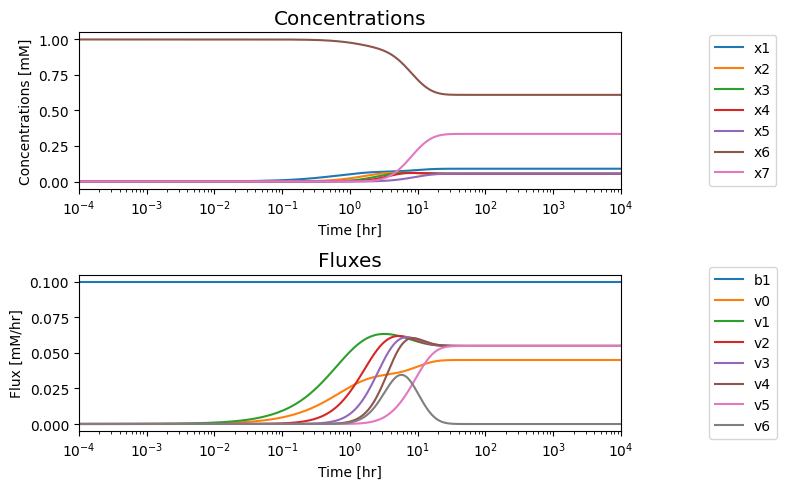

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Fluxes", XL_FONT));
fig.tight_layout()

We note that in the eventual steady state that; i) all the fluxes in the biosynthetic pathway are equal, ii) that the overall flux balance on inputs and outputs, $b_1 = v_0 + v_5$, holds, and iii) the inhibitor binding reactions, $v_6$ and $v_7$, go to equilibrium, i.e. $v_6= v_7= 0.$

In [23]:
time_points = [1e0, 1e1, 1e2, 1e3]
# Make a pandas DataFrame using a dictionary and generators
pd.DataFrame({rxn: [round(value, 3) for value in flux_func(time_points)]
              for rxn, flux_func in flux_sol.items()}, 
             index=["t=%i" % t for t in time_points])

,b1,v0,v1,v2,v3,v4,v5,v6
t=1,0.1,0.026,0.051,0.023,0.007,0.002,0.000,0.001
t=10,0.1,0.040,0.058,0.059,0.059,0.060,0.035,0.022
t=100,0.1,0.045,0.055,0.055,0.055,0.055,0.055,-0.000
t=1000,0.1,0.045,0.055,0.055,0.055,0.055,0.055,0.000


**A numerical QC/QA**: Check the size of the enzyme pool at various time points

In [24]:
conc_sol.make_aggregate_solution(
    "Total_Enzyme", equation="x2 + x6 + x7",
    variables=["x2", "x6", "x7"]);

pd.DataFrame({
    "Total Enzyme": conc_sol["Total_Enzyme"](time_points)},
    index=["t=%i" % t for t in time_points]).T

,t=1,t=10,t=100,t=1000
Total Enzyme,1.0,1.0,1.0,1.0


As we did with the unregulated system, we can compute the steady state and define it as the initial condition for any subsequent simulations.

In [25]:
monomer_ss = sim_monomer.find_steady_state(
    monomer, strategy="simulate", update_values=True,
    verbose=True)

Setting output selections
Setting simulation values for 'Monomer'
Setting output selections
Getting time points
Simulating 'Monomer'
Found steady state for 'Monomer'.
Updating 'Monomer' values
Adding 'Monomer' simulation solutions to output


### Dynamic states: regulated model
#### Simulate the response to a step change in the input $b_1$:
We will now simulate the feedback model's response to an x-fold change in the input flux $b_1$ and compare it to the unregulated model in order to analyze the effectiveness of the regulatory mechanism. The simulation results can be displayed as time profiles of the (a) concentrations, (b) fluxes and (c) of $(v_1, v_5)$, providing an initial visualization of the solution as before.

In [26]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 50)
conc_sol, flux_sol = sim_monomer.simulate(
    monomer, time=(t0, tf),
    perturbations=perturbation_dict)

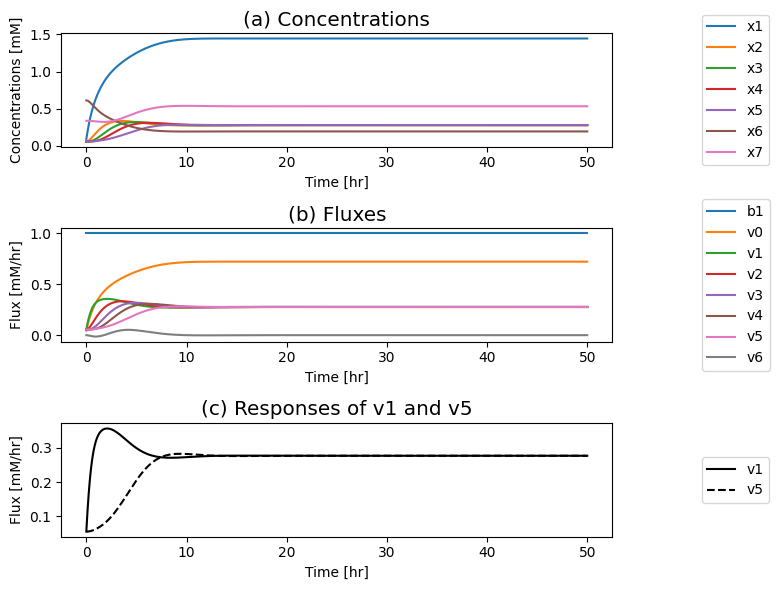

In [27]:
fig_9_8, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("(a) Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(b) Fluxes", XL_FONT));

plot_time_profile(
    flux_sol, observable=["v1", "v5"], ax=ax3, 
    legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(c) Responses of v1 and v5", XL_FONT),
    color="black", linestyle=["-", "--"]);
fig_9_8.tight_layout()

**Figure 9.8:** The time profiles for the concentrations and fluxes involved in the simple feedback control loop. The parameter values used are $k_0 = 0.5$, $k_1 = k_2 = k_3 = k_4 = k_5 = 1$, and $e_t = 1$. Just prior to time zero, the input rate is $b_1 = 0.1$, the inhibitor binding rate is $k_6$=10, and the feedback loop is at steady state where $x_1 = 0.090$, $x_2 = x_3 = x_4 = x_5 = 0.055$, $x_6 = 0.610$, $x_7 = 0.335$. The input rate is changed to a specified number at time zero and the dynamic response is simulated. (a) The concentrations as a function of time. (b) The reaction fluxes as a function of time. (c) Dynamic response of $v_1$ and $v_5$ to the perturbation.

If you put a 10-fold change on $b_1$ you can see in: Panel (a) that the concentration of the inhibited enzyme $(x_7)$ increases as the concentration of the inhibitor $(x_5)$ rises; Panel (b) that the reduction of the concentration active enzymes leads to a reduction in the fluxes into the biosynthetic pathway creating an overshoot in the flux values; and in Panel (c) how the input $(v_1)$ and the output $(v_5)$ of the biosynthetic pathway come into a steady state. 


First the input rises rapidly, and it reaches a peak as the output flux begins to rise as a consequence of buildup of $x_5$. The buildup of $x_5$ leads to a reduction of the input flux through the feedback mechanism until it matches the output and steady state is reached. 

the increased input rate leads to an immediate increase in $x_1$ Then, the intermediates in the reaction chain $(x_2, x_3, x_4, x_5)$ rise serially over time; see Figure 9.8a. The build-up of $x_5$ leads to the sequestering of the enzyme $x_6$ in its inactive form $x_7$, through activation of $v_6$; see Figure 9.8b. As the free enzyme concentration drops, the influx to the reaction chain $(v_{1})$ and the inhibitory flux $(v_{6})$ drops towards its steady state. Note that the concentrations and fluxes overshoot their eventual steady state.


These complex dynamics can be further examined and simplified using dynamic phase portraits. We can graph the input and the output flux in a phase portrait, and compare it to the response of the unregulated system that we simulated in the previous section, see Figure 9.9a. The difference is the pull back in $v_5$ and that leads to a steady state on the 45 degree line that is much closer to the initial state as compared to the final state of the unregulated system.  We can also graph the over all flux balance as before by plotting the two pathway outputs $v_0$ and $v_5$ against one another. The endpoint of the simulation will be on the 45 degree line whose y-intercept is given by the numerical value of $b_1$.  The trajectory of the regulated system is more in the horizontal direction than the unregulated system, and the final resting point shows that much more of the disturbance comes out of the primary pathway than out of the biosynthetic pathway. 

Even if the feedback regulation acts to overcome the effects of the disturbance in $b_1$, it does not eliminate the additional flux that it creates in the biosynthetic pathway.

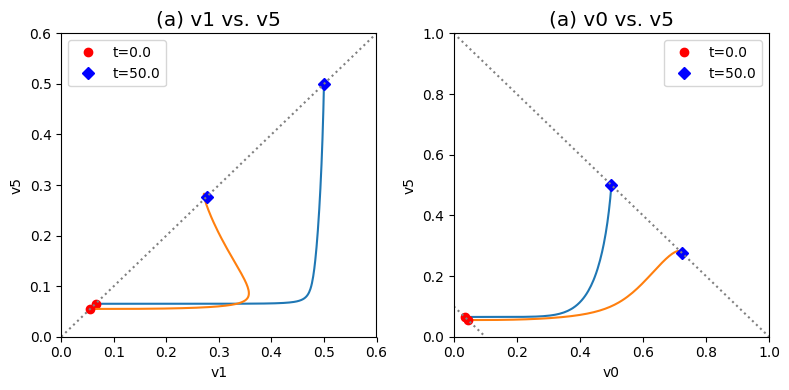

In [28]:
fig_9_9, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
(ax1, ax2) = axes.flatten()


for model, sim in zip(models, simulations):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict)

    # Plot v1 vs. v5
    plot_phase_portrait(
        flux_sol, x="v1", y="v5", ax=ax1,
        xlim=(0, 0.6), ylim=(0, 0.6),
        xlabel="v1", ylabel="v5",
        title=("(a) v1 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

    # Plot v0 vs. v5
    plot_phase_portrait(
        flux_sol, x="v0", y="v5", ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(0, 1), ylim=(0, 1),
        xlabel="v0", ylabel="v5", 
        title=("(a) v0 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_9.tight_layout()

**Figure 9.9:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$. The red points are at the start time and the blue points are at the final time.

As we can surmise from the above simulations, the state of the enzyme is a key consideration.  Either it is inhibited $(x_7)$ or it is actively carrying out catalysis $(x_2 + x_6)$.  Since all the forms of the enzyme from a constant pool (the time invariant pool in the left null space) we can graph $x_2 + x_6$ against $x_7$. This plot will be on the -45 degree line with the x- and y-axis intercepts corresponding to the total amount of enzyme present. In the initial steady state 66.5% of the enzyme pool is active. For a 10-fold increase in $b_1$, the active form of the enzyme is 47.9% of the total enzyme present. 

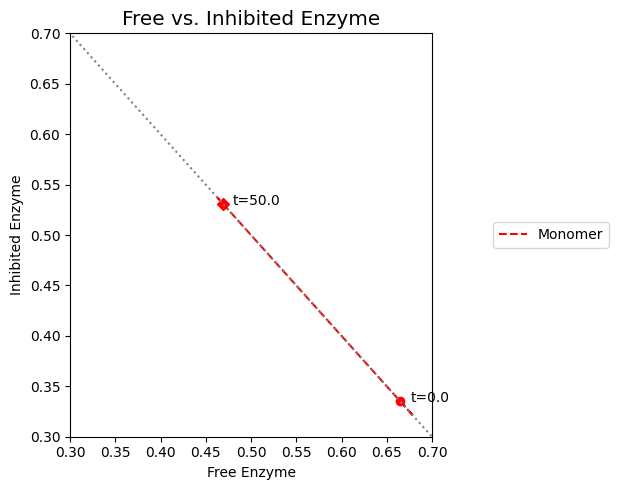

In [29]:
enzyme_pools = {
    "Free": ["x2 + x6", ["x2", "x6"]],
    "Monomer_Inhibited": ["x7", ["x7"]]}
for pool_id, args in enzyme_pools.items():
    equation, variables = args
    conc_sol.make_aggregate_solution(
        pool_id, equation, variables)

fig_9_10, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

plot_phase_portrait(
    conc_sol, x="Free", y=monomer.id + "_Inhibited", ax=ax,
    legend=([monomer.id], "right outside"), 
    xlim=(0.3, .7), ylim=(0.3, .7),
    xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
    color=["red"], linestyle=["--"],
    title=("Free vs. Inhibited Enzyme", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_color=["red"],
    annotate_time_points_labels=True)

# Add line representing the constant enzyme 
ax.plot([0, 1], [1, 0], color="grey", linestyle=":");
fig_9_10.tight_layout()

**Figure 9.10:** Dynamic phase portrait of the inhibited enzyme vs. the free enzyme for the monomer. The mass balance between  $(x_2 + x_6)$ and $x_7$ can be seen. The motion of the occurs on a line with a slope of -1.

For this numerical example, the feedback control is not working very
well, as $v_1$ does not return close to its original value, and the system is not very ‘robust’ with respect to changes in $b_1$. Once the equations have been set up, simulations can be repeated from different initial conditions and parameter values. For example, the user can adjust the inhibition by changing the values of $k_6$ and $k_{-6}$. Specifically, if we set $k_6 = 0$, then there is no inhibition and we have the unregulated model again. Conversely, if $k_6$ and $k_6/k_{-6}$ are high, then the inhibition is rapid and tight.

#### Pool sizes and their states: monomer

This example introduces an important concept of an enzyme pool size and its state. In this case, the total enzyme
$(e_\mathrm{tot} = x_{2} + x_{6} + x_{7})$ is a constant. The fraction of the enzyme that is in the inhibited form can be computed for the monomer:

$$\begin{equation} f_{inhibited} = \frac{x_7}{x_{2} + x_{6} + x_{7}} \tag{9.5} \end{equation}$$

Therefore the fraction of free enzyme can be computed for the monomer:

$$\begin{equation} f_{free} = \frac{x_{2} + x_{6}}{x_2 + x_6 + x_7} \tag{9.6} \end{equation}$$

is the fraction of the total enzyme that is inhibited and prevented from catalyzing the reaction. This sequestering of catalytic activity is essentially how the feedback works. At time zero, the fraction of inhibited enzyme is approximately 0.34; thus, about a third of the enzyme is in a catalytically inactive state. When the $b_{1}$ flux is increased,
the concentration of $x_{1}$ builds and increases the flux $(v_{1})$ into the reaction chain. The subsequent buildup of the end product $(x_{1})$ leads to an adjustment of the inhibited fraction of the enzyme to approximately 0.53 and, thus, reduces the input flux into the reaction chain. Note that the fraction of inhibited enzyme also corresponds to the fraction of occupied inhibition sites, and the fraction of free enzyme correspond to the fraction of unoccupied inhibition sites in the case of the monomer.

#### Breaking down the steady states into the pathway vectors: regulated model
As before, we can evaluate the steady state solutions by breaking them down into a linear combination of the two pathway vectors in the null space.

In [30]:
monomer_ss_perturbed = sim_monomer.find_steady_state(
    monomer, strategy="simulate", perturbations=perturbation_dict)

unperturbed = [round(value,3) for value in monomer_ss[1].values()]
perturbed = [round(value,3) for value in monomer_ss_perturbed[1].values()]

pd.DataFrame(
    np.vstack((ns.T, unperturbed, perturbed)), 
    index=["Nullspace Path 1", "Nullspace Path 2", "Unperturbed fluxes", "Perturbed fluxes"], 
    columns=[rxn.id for rxn in monomer.reactions],
    dtype=np.float64)

,b1,v0,v1,v2,v3,v4,v5,v6
Nullspace Path 1,1.0,0.000,1.000,1.000,1.000,1.000,1.000,0.0
Nullspace Path 2,1.0,1.000,0.000,0.000,0.000,0.000,0.000,0.0
Unperturbed fluxes,0.1,0.045,0.055,0.055,0.055,0.055,0.055,0.0
Perturbed fluxes,1.0,0.723,0.277,0.277,0.277,0.277,0.277,0.0


The overall flux balance is $b_1 = v_0 + v_5$. Thus, the biosynthetic pathway goes from 55% of $b_1$ to 27.7% of $b_1$ after the perturbation. In contrast, the unregulated system goes from 65% to 50% of $b_1$. Therefore, the regulation diverts a part of the incoming flux of $b_1$ out the primary pathway.

**A numerical QC/QA:** The loadings on $v_0$ and $v_5$ should add up to $b_1$: 

In [31]:
before = monomer_ss[1]["v0"] +\
         monomer_ss[1]["v5"] == monomer_ss[1]["b1"]
after = monomer_ss_perturbed[1]["v0"] +\
        monomer_ss_perturbed[1]["v5"] == monomer_ss_perturbed[1]["b1"]

pd.DataFrame([before, after],
             index=["Before Perturbation", "After Perturbation"],
             columns=["Add up to b1?"])

,Add up to b1?
Before Perturbation,True
After Perturbation,True


## Dimer Model of the Regulated Enzyme
### Building on a scaffold  
The reaction network studied in the previous section represents the basic framework for feedback regulation of a biosynthetic pathway. This schema operates in a cellular environment that has additional regulatory features. These can be built on top of this basic structure.  We will consider two additional regulatory mechanisms. First, we consider more and more realistic mechanisms for $x_5$ binding to the regulated enzyme. Second, we look at the regulation of protein synthesis and more elaborate and realistic schemas for the inhibition of the first enzyme in the pathway. The two can be combined. Such additions take into account more processes and make the models more realistic.  

### More realistic mechanism for $x_5$ binding
Regulatory enzymes have a more complex mechanism than simply having an active and inactive state, as denoted by $x_6$ and $x_7$ in Section 9.3. Regulatory enzymes often have a series of binding sites for inhibitory molecules. One mechanism for such serial binding is the symmetry model, described in Section 5.5. The reaction mechanisms (using the same compound names as in Section 9.3) for a dimer are shown below.

![Figure-9-11](../images/Ch9/Figure-9-11.png)

**Figure 9.11:** The reaction mechanism for a dimer.

For the dimer case, $x_7$ has one ligand bound and $x_8$ has two.

### Define dimer model
Add the first additional binding reaction and adjust the corresponding rate equations for the effective concentrations of the multiple binding sites.

![Figure-9-12](../images/Ch9/Figure-9-12.png)

**Figure 9.12:** Visual representation of a prototypical negative feedback loop for a biosynthetic pathway for the dimer model. The additional dimer reactions are shown in light blue.

In [32]:
# Copy the monomer model
dimer = monomer.copy()
# Change the model ID
dimer.id = "Dimer"

# Define new metabolite 
x8 = MassMetabolite("x8")
mets = dimer.metabolites

# Define new reaction and set parameters
v7 = MassReaction("v7"); 
v7.add_metabolites({mets.x5: -1, mets.x7: -1, x8:1})
v7.get_mass_action_rate(rate_type=2, update_reaction=True)
# Add Reaction to the model
dimer.add_reactions([v7])

### Null spaces and their content: dimer model
When we look at the right null space, we observe that the addition of another inhibition step did not change the pathway vectors.

In [33]:
# Obtain nullspace
ns = nullspace(dimer.S, rtol=1e-10)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

# Find the viable pathways using linear combinations of the nullspace
ns[1] = (3*ns[0] - ns[1])/13
ns[0] = ns[0] - 3 * ns[1]

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in dimer.reactions],
             columns=["Path 1", "Path 2"], dtype=np.int64)

,Path 1,Path 2
b1,1,1
v0,0,1
v1,1,0
v2,1,0
v3,1,0
v4,1,0
v5,1,0
v6,0,0
v7,0,0


The left null space has one pool: the conservation of the enzyme that is found in the active form $(x_6)$, in the intermediary complex $(x_2)$ and in the inhibited forms $(x_7,\ x_8)$ when it is bound to the inhibitor $(x_5)$.

In [34]:
# Obtain left nullspace
lns = left_nullspace(dimer.S, rtol=1e-10)
# Iterate through left nullspace and divide by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(row[np.nonzero(row)])
    lns[i] = np.array(row/minval)
    # Ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in lns[i]])

#Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, columns=dimer.metabolites, 
             index=["Total Enzyme"], dtype=np.int64)

,x1,x2,x3,x4,x5,x6,x7,x8
Total Enzyme,0,1,0,0,0,1,1,1


### Steady state: dimer model
We now evaluate the steady state by simulating the system to very long times. 

In [35]:
# Following Figure 9.11, adjust the parameters for v6 
# and use them to set the parameters for v7. 
# For demonstration purposes
rxns = dimer.reactions
rxns.v6.kf = 10*2
rxns.v7.kf = 10*1

rxns.v6.kr = 1*1
rxns.v7.kr = 1*2

# Define initial conditions
dimer.update_initial_conditions(
    dict((met, 0) if met.id != "x6"
         else (met, 1) for met in dimer.metabolites))

We simulate the model to obtain the concentration and flux solutions, then we plot the time profile of the concentrations and the fluxes.  

In [36]:
(t0, tf) = (0, 1e4)
sim_dimer = Simulation(dimer, verbose=True)
conc_sol, flux_sol = sim_dimer.simulate(
    dimer, time=(t0, tf),
    interpolate=True, verbose=True)

# Place models and simulations into lists for later
models += [dimer]
simulations += [sim_dimer]

Successfully loaded MassModel 'Dimer' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Dimer'
Simulating 'Dimer'
Simulation for 'Dimer' successful
Adding 'Dimer' simulation solutions to output
Updating stored solutions


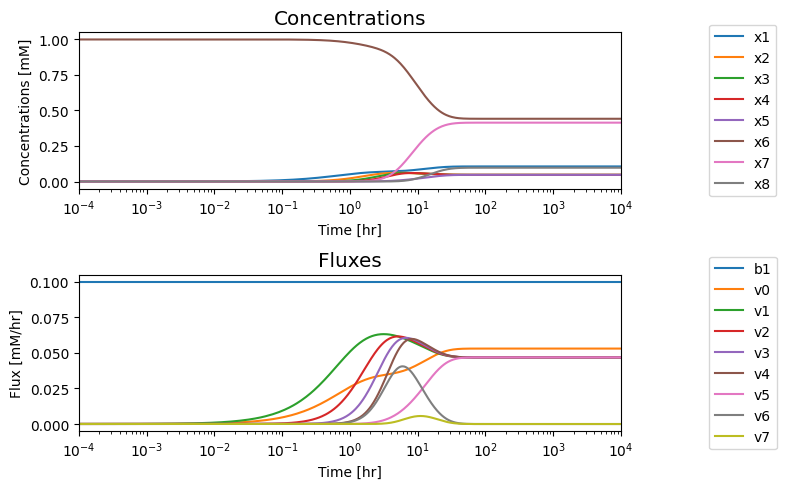

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Fluxes", XL_FONT));
fig.tight_layout()

We note that in the eventual steady state that; i) all the fluxes in the biosynthetic pathway are equal, ii) that the overall flux balance on inputs and outputs, $b_1 = v_0 + v_5$, holds, and iii) the inhibitor binding reactions, $v_6$ and $v_7$, go to equilibrium, i.e. $v_6 = v_7 = 0$.

In [38]:
time_points = [1e0, 1e1, 1e2, 1e3]
# Make a pandas DataFrame using a dictionary and generators
pd.DataFrame({rxn: [round(value, 3) for value in flux_func(time_points)]
              for rxn, flux_func in flux_sol.items()}, 
             index=["t=%i" % t for t in time_points])

,b1,v0,v1,v2,v3,v4,v5,v6,v7
t=1,0.1,0.026,0.051,0.023,0.007,0.002,0.000,0.001,0.000
t=10,0.1,0.042,0.056,0.057,0.058,0.059,0.021,0.030,0.006
t=100,0.1,0.053,0.047,0.047,0.047,0.047,0.047,0.000,0.000
t=1000,0.1,0.053,0.047,0.047,0.047,0.047,0.047,0.000,0.000


**A numerical QC/QA**: Check the size of the enzyme pool at various time points.

In [39]:
conc_sol.make_aggregate_solution(
    "Total_Enzyme", equation="x2 + x6 + x7 + x8",
    variables=["x2", "x6", "x7", "x8"]);

pd.DataFrame({
    "Total Enzyme": conc_sol["Total_Enzyme"](time_points)},
    index=["t=%i" % t for t in time_points]).T

,t=1,t=10,t=100,t=1000
Total Enzyme,1.0,1.0,1.0,1.0


In [40]:
dimer_ss = sim_dimer.find_steady_state(
    dimer, strategy="simulate", update_values=True,
    verbose=True)

Setting output selections
Setting simulation values for 'Dimer'
Setting output selections
Getting time points
Simulating 'Dimer'
Found steady state for 'Dimer'.
Updating 'Dimer' values
Adding 'Dimer' simulation solutions to output


### Dynamic states: dimer model
We now simulate the dimer model's response to a 10-fold change in the input flux $b_1$ and compare it to the previous models in order to analyze the effectiveness of the different regulatory mechanisms. 

#### Simulate the response to a step change in the input $b_1$: dimer model
The simulation results can be displayed as time profiles of the concentrations and fluxes, providing an initial visualization of the solution.

In [41]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 50)
conc_sol, flux_sol = sim_dimer.simulate(
    dimer, time=(t0, tf),
    perturbations=perturbation_dict)

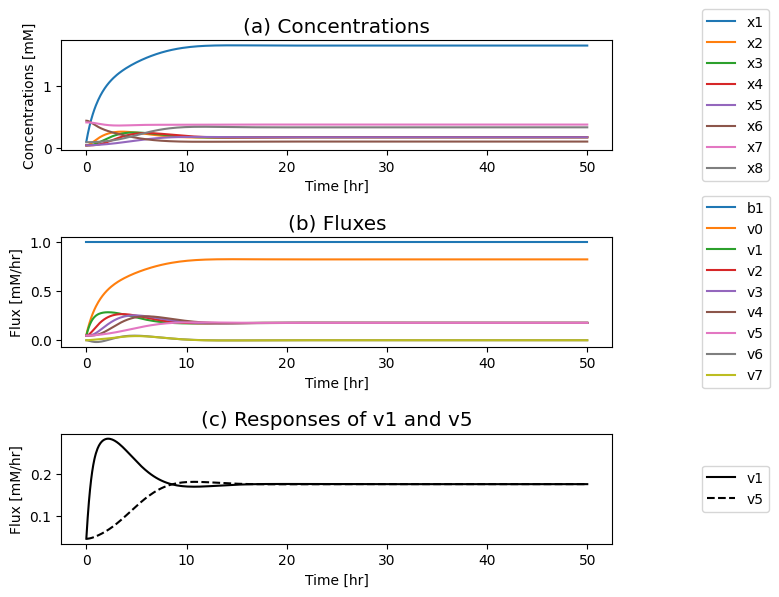

In [42]:
fig_9_13, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("(a) Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(b) Fluxes", XL_FONT));

plot_time_profile(
    flux_sol, observable=["v1", "v5"], ax=ax3, 
    legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(c) Responses of v1 and v5", XL_FONT),
    color="black", linestyle=["-", "--"]);
fig_9_13.tight_layout()

**Figure 9.13:** Simulation of the dimeric system where the influx of $b_1$ is varied. (a) The concentration profiles. (b) The flux profiles. (c) Comparison of the flux into $(v_1)$ and out of $(v_5)$ the reaction sequence.

Compare the performance of the unregulated, feedback, and dimer systems to reject the disturbance in the input flux.

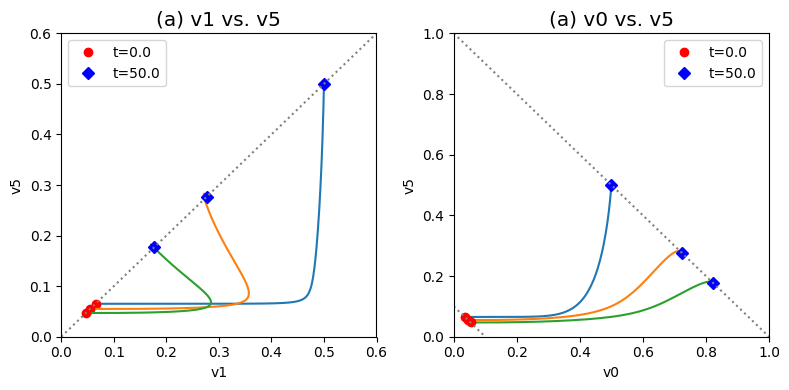

In [43]:
fig_9_14, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
(ax1, ax2) = axes.flatten()

for model, sim in zip(models, simulations):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict)

    # Plot v1 vs. v5
    plot_phase_portrait(
        flux_sol, x="v1", y="v5", ax=ax1,
        xlim=(0, 0.6), ylim=(0, 0.6),
        xlabel="v1", ylabel="v5",
        title=("(a) v1 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

    # Plot v0 vs. v5
    plot_phase_portrait(
        flux_sol, x="v0", y="v5", ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(0, 1), ylim=(0, 1),
        xlabel="v0", ylabel="v5", 
        title=("(a) v0 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_14.tight_layout()

**Figure 9.14:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$.The model is the simple feedback loop for the same conditions as in Figure 9.9 except for the dimeric form of the inhibition mechanism. The red points are at the start time and the blue points are at the final time.


#### Pool sizes and their states: dimer model
The fraction of the enzyme that is in the inhibited form can be computed for the dimer:

$$\begin{equation} f_{inhibited} = \frac{x_7 + x_8}{x_2 + x_6 + x_7 + x_8} \tag{9.7} \end{equation}$$

Therefore the fraction of free enzyme can be computed for the dimer:

$$\begin{equation} f_{free} = \frac{x_2 + x_6}{x_2 + x_6 + x_7 + x_8} \tag{9.8} \end{equation}$$


We can also look at the fractions of occupied and unoccupied inhibitor sites for the dimer:

$$\begin{equation} f_{occupied} = \frac{x_7 + 2x_8}{2(x_2 + x_6 + x_7 + x_8)} \tag{9.9} \end{equation}$$

Therefore the fraction of unoccupied enzyme can be computed for the dimer:

$$\begin{equation} f_{unoccupied} = \frac{2x_2 + 2x_6 + x_7}{2(x_2 + x_6 + x_7 + x_8)} \tag{9.10} \end{equation}$$



The increased number of binding sites for $x_5$ on the enzyme $(x_6)$ increases the efficacy of the regulatory mechanisms on the ability of the system to reject the disturbance imposed on it.  

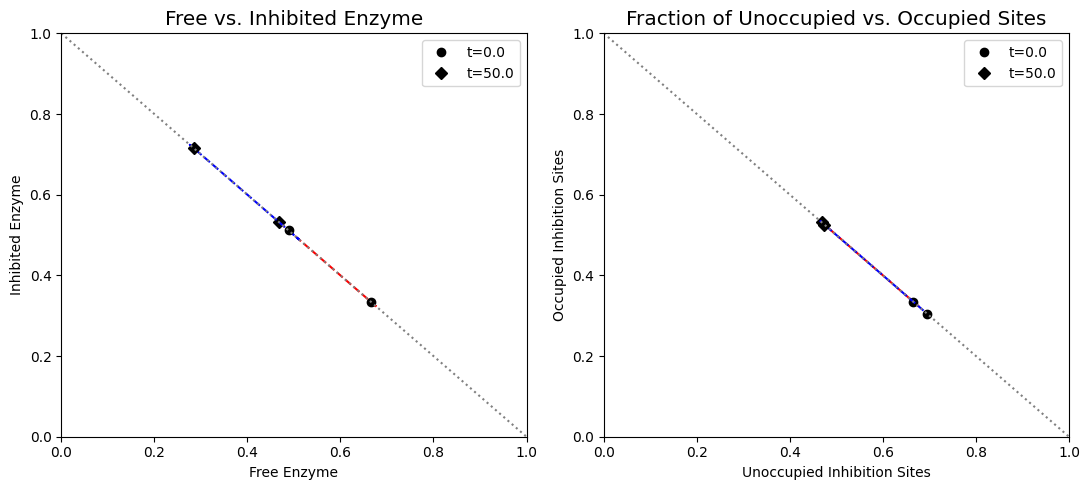

In [44]:
monomer_pools = {
    "Free": "x2 + x6",
    "Inhibited": "x7",
    "Fraction_Unoccupied": "(x2 + x6) / (x2 + x6 + x7)" ,
    "Fraction_Occupied": "(x7) / (x2 + x6 + x7)",
}

dimer_pools = {
    "Free": "x2 + x6",
    "Inhibited": "x7 + x8",
    "Fraction_Unoccupied": "(2*x2 + 2*x6 + x7) / 2*(x2 + x6 + x7 + x8)" ,
    "Fraction_Occupied": "(x7 + 2*x8) / 2*(x2 + x6 + x7 + x8)",
}

enzyme_pools = {
    "Monomer": monomer_pools,
    "Dimer": dimer_pools,
}

colors = ["red", "blue"]

fig_9_15,  axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
ax1, ax2 = axes.flatten()

for i, (model, sim) in enumerate(zip(models[1:], simulations[1:])):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict)
    
    pools = enzyme_pools[model.id]
    for pool_id, equation in pools.items():
        conc_sol.make_aggregate_solution(pool_id, equation)
    
    plot_phase_portrait(
        conc_sol, x="Free", y="Inhibited", ax=ax1,
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
        color=colors[i], linestyle=["--"],
        title=("Free vs. Inhibited Enzyme", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="best")

    plot_phase_portrait(
        conc_sol, x="Fraction_Unoccupied", y="Fraction_Occupied", ax=ax2,
        legend=([model.id], "right outside"), 
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Unoccupied Inhibition Sites", ylabel="Occupied Inhibition Sites",
        color=colors[i], linestyle=["--"],
        title=("Fraction of Unoccupied vs. Occupied Sites", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="best")


# Add line representing the constant enzyme 
ax1.plot([0, 1], [1, 0], color="grey", linestyle=":");
ax2.plot([0, 1], [1, 0], color="grey", linestyle=":");
fig_9_15.tight_layout()

**Figure 9.15:** (a) Dynamic phase portrait of inhibited enzyme vs. free enzyme for the monomer and the dimer. (b) Dynamic phase portrait of the fraction of occupied inhibitor sites vs. the fraction of unoccupied enzyme for the monomer and the dimer. Note that there is more inhibited enzyme form of the dimer than the monomer, but the fraction of occupied vs unoccupied sites is similar for both enzymes.


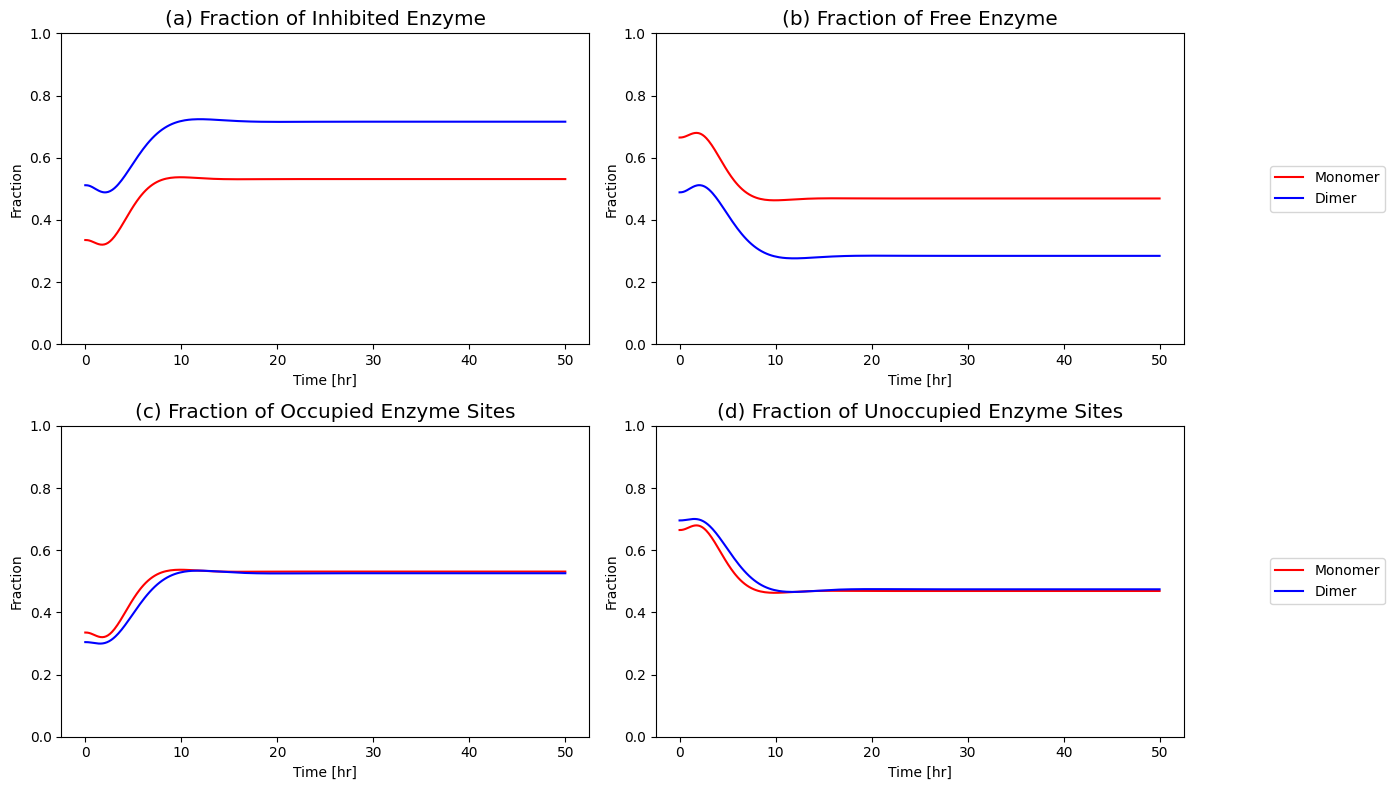

In [45]:
fig_9_16, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), )
(ax1, ax2, ax3, ax4) = axes.flatten()

for i, (model, sim) in enumerate(zip(models[1:], simulations[1:])):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    # Make Fraction of Free Enzyme pool
    conc_sol.make_aggregate_solution(
        "Fraction_Free", equation="{0} / ({0} + {1})".format("Free", "Inhibited"),
        variables=["Free", "Inhibited"])
    # Make Fraction of Inhibited Enzyme pool
    conc_sol.make_aggregate_solution(
        "Fraction_Inhibited", equation="{1} / ({0} + {1})".format("Free", "Inhibited"),
        variables=["Free", "Inhibited"])
    
    plot_time_profile(
        conc_sol, observable="Fraction_Inhibited", ax=ax1, 
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(a) Fraction of Inhibited Enzyme", XL_FONT),
        color=colors[i])

    plot_time_profile(
        conc_sol, observable="Fraction_Free", ax=ax2, 
        legend=(model.id, "right outside"),
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(b) Fraction of Free Enzyme", XL_FONT),
        color=colors[i])
    
    plot_time_profile(
        conc_sol, observable="Fraction_Occupied", ax=ax3, 
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(c) Fraction of Occupied Enzyme Sites", XL_FONT),
        color=colors[i])

    plot_time_profile(
        conc_sol, observable="Fraction_Unoccupied", ax=ax4, 
        legend=(model.id, "right outside"),
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(d) Fraction of Unoccupied Enzyme Sites", XL_FONT),
        color=colors[i])
fig_9_16.tight_layout()

**Figure 9.16:** (a) Fraction of inhibited enzyme, (b) fraction of free enzyme, (c) fraction of occupied enzyme sites and (d) fraction of unoccupied enzyme sites for the monomer and dimer models.

#### Breaking down the steady states into the pathway vectors: dimer model
We can study the steady state solutions by breaking them down into a linear combination of the two pathway vectors in the null space.

In [46]:
dimer_ss_perturbed = sim.find_steady_state(
    dimer, strategy="simulate", perturbations=perturbation_dict)

unperturbed = [round(value,3) for value in dimer_ss[1].values()]
perturbed = [round(value,3) for value in dimer_ss_perturbed[1].values()]

pd.DataFrame(
    np.vstack((ns.T, unperturbed, perturbed)), 
    index=["Nullspace Path 1", "Nullspace Path 2", "Unperturbed fluxes", "Perturbed fluxes"], 
    columns=[rxn.id for rxn in dimer.reactions],
    dtype=np.float64)

,b1,v0,v1,v2,v3,v4,v5,v6,v7
Nullspace Path 1,1.0,0.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0
Nullspace Path 2,1.0,1.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0
Unperturbed fluxes,0.1,0.053,0.047,0.047,0.047,0.047,0.047,0.0,-0.0
Perturbed fluxes,1.0,0.823,0.177,0.177,0.177,0.177,0.177,0.0,-0.0


The overall flux balance is $b_1 = v_0 + v_5$. Thus, the first pathway goes from 45% of $b_1$ to 73% of $b_1$ after the perturbation and the second pathway goes from a 55% of $b_1$ to 27.2% of $b_1$ after the perturbation. So the dimer is more effective in preventing flux from going down the biosynthetic pathway as compared to the monomer. Still, a fair number of the disturbance does go down the biosynthetic pathway so the regulation does not reject the entire disturbance. 

**A numerical QC/QA:** The loadings on $v_0$ and $v_5$ should add up to $b_1$: 

In [47]:
before = dimer_ss[1]["v0"] +\
         dimer_ss[1]["v5"] == dimer_ss[1]["b1"]
after = dimer_ss_perturbed[1]["v0"] +\
        dimer_ss_perturbed[1]["v5"] == dimer_ss_perturbed[1]["b1"]

pd.DataFrame([before, after],
             index=["Before Perturbation", "After Perturbation"],
             columns=["Add up to b1?"])

,Add up to b1?
Before Perturbation,True
After Perturbation,True


## Tetramer Model of the Regulated Enzyme
Expanding on the mechanism in symmetry model, described in Section 5.5, a  the reaction mechanisms (using the same compound names as in Section 9.3) for a tetramer are shown below.

![Figure-9-17](../images/Ch9/Figure-9-17.png)

**Figure 9.17:** The reaction mechanism for a tetramer.

### Define tetramer model
We will now examine the tetramer symmetry model by adding all additional binding reactions and adjust the corresponding rate equations for the effective concentrations of the multiple binding sites.

![Figure-9-18](../images/Ch9/Figure-9-18.png)

**Figure 9.18:** Visual representation of a prototypical negative feedback loop for a biosynthetic pathway for a tetramer model. The additional tetramer reactions are shown in light blue.

In [48]:
# Copy the dimer model
tetramer = dimer.copy()
# Change the model ID
tetramer.id = "Tetramer"

# Define new metabolites 
x9 = MassMetabolite("x9")
x10 = MassMetabolite("x10")
mets = tetramer.metabolites

# Define new reaction and set parameters
v8 = MassReaction("v8"); 
v8.add_metabolites({mets.x5: -1, mets.x8: -1, x9:1})
v8.get_mass_action_rate(rate_type=2, update_reaction=True)

v9 = MassReaction("v9"); 
v9.add_metabolites({mets.x5: -1, x9: -1, x10:1})
v9.get_mass_action_rate(rate_type=2, update_reaction=True)

# Add Reactions to the model
tetramer.add_reactions([v8, v9])

### Null spaces and their content: tetramer model
When we look at the right null space, we observe that the additional inhibition steps did not change the pathway vectors.

In [49]:
# Obtain nullspace
ns = nullspace(tetramer.S, rtol=1e-10)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

ns[1] = (ns[0] + 2*ns[1])/7
ns[0] = (ns[0] - ns[1])/2

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in tetramer.reactions],
             columns=["Path 1", "Path 2"], dtype=np.int64)

,Path 1,Path 2
b1,1,1
v0,0,1
v1,1,0
v2,1,0
v3,1,0
v4,1,0
v5,1,0
v6,0,0
v7,0,0
v8,0,0


The left null space has one pool: the conservation of the enzyme that is found in the active form $(x_6)$, in the intermediary complex $(x_2)$ and in the inhibited forms $(x_7,\ x_8,\ x_9,\ x_{10})$ when it is bound to the inhibitor $(x_5)$.

In [50]:
# Obtain left nullspace
lns = left_nullspace(tetramer.S, rtol=1e-10)
# Iterate through left nullspace and divide by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(row[np.nonzero(row)])
    lns[i] = np.array(row/minval)
    # Ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in lns[i]])

#Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, columns=tetramer.metabolites, 
             index=["Total Enzyme"], dtype=np.int64)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
Total Enzyme,0,1,0,0,0,1,1,1,1,1


### Steady state: tetramer model
We now evaluate the steady state by simulating the system to very long times. 

In [51]:
# Following Figure 9.11, adjust the parameters for v6 
# and use them to set the parameters for v7. 
rxns = tetramer.reactions
rxns.v6.kf = 10*4
rxns.v7.kf = 10*3
rxns.v8.kf = 10*2
rxns.v9.kf = 10*1

rxns.v6.kr = 1*1
rxns.v7.kr = 1*2
rxns.v8.kr = 1*3
rxns.v9.kr = 1*4

# Define initial conditions
tetramer.update_initial_conditions(
    dict((met, 0) if met.id != "x6"
         else (met, 1) for met in tetramer.metabolites))

We simulate the model to obtain the concentration and flux solutions, then we plot the time profile of the concentrations and the fluxes.

In [52]:
(t0, tf) = (0, 1e4)
sim_tetramer = Simulation(tetramer, verbose=True)
conc_sol, flux_sol = sim_tetramer.simulate(
    tetramer, time=(t0, tf),
    interpolate=True, verbose=True)

# Place models and simulations into lists for later
models += [tetramer]
simulations += [sim_tetramer]

Successfully loaded MassModel 'Tetramer' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Tetramer'
Simulating 'Tetramer'
Simulation for 'Tetramer' successful
Adding 'Tetramer' simulation solutions to output
Updating stored solutions


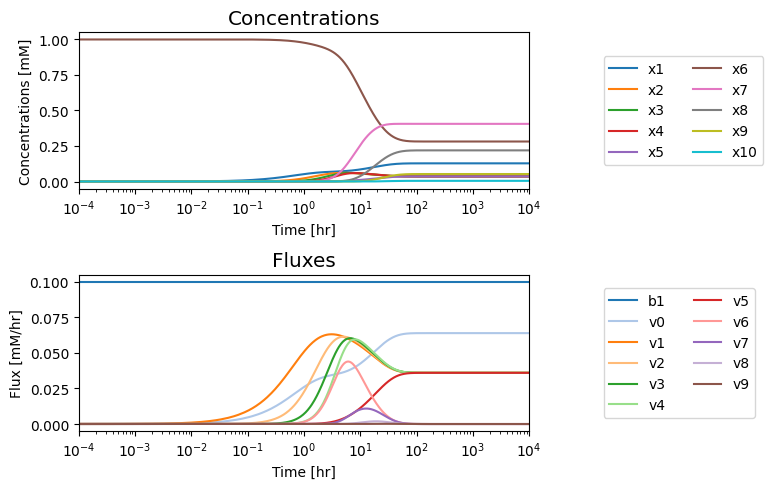

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx", 
    xlim=(1e-4, 1e4),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Fluxes", XL_FONT));
fig.tight_layout()

We note that in the eventual steady state that; i) all the fluxes in the biosynthetic pathway are equal, ii) that the overall flux balance on inputs and outputs, $b_1 = v_0 + v_5$, holds, and iii) the inhibitor binding reactions, $v_6,\ v_7,\ v_8,$ and $v_9$, go to equilibrium, i.e. $v_6 = v_7 = v_8 = v_9 = 0$.

In [54]:
time_points = [1e0, 1e1, 1e2, 1e3]
# Make a pandas DataFrame using a dictionary and generators
pd.DataFrame({rxn: [round(value, 3) for value in flux_func(time_points)]
              for rxn, flux_func in flux_sol.items()}, 
             index=["t=%i" % t for t in time_points])

,b1,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
t=1,0.1,0.026,0.051,0.023,0.007,0.002,0.000,0.002,0.00,0.000,0.0
t=10,0.1,0.043,0.055,0.056,0.057,0.058,0.011,0.035,0.01,0.001,0.0
t=100,0.1,0.064,0.036,0.036,0.036,0.036,0.036,0.000,0.00,0.000,0.0
t=1000,0.1,0.064,0.036,0.036,0.036,0.036,0.036,-0.000,0.00,0.000,-0.0


**A numerical QC/QA**: Check the size of the enzyme pool at various time points.

In [55]:
conc_sol.make_aggregate_solution(
    "Total_Enzyme", equation="x2 + x6 + x7 + x8 + x9 + x10",
    variables=["x2", "x6", "x7", "x8", "x9", "x10"]);

pd.DataFrame({
    "Total Enzyme": conc_sol["Total_Enzyme"](time_points)},
    index=["t=%i" % t for t in time_points]).T

,t=1,t=10,t=100,t=1000
Total Enzyme,1.0,1.0,1.0,1.0


In [56]:
tetramer_ss = sim_tetramer.find_steady_state(
    tetramer, strategy="simulate", update_values=True,
    verbose=True)

Setting output selections
Setting simulation values for 'Tetramer'
Setting output selections
Getting time points
Simulating 'Tetramer'
Found steady state for 'Tetramer'.
Updating 'Tetramer' values
Adding 'Tetramer' simulation solutions to output


### Dynamic states: tetramer model
We now simulate the tetramers model's response to a 10-fold change in the input flux $b_1$ and compare it to the previous models in order to analyze the effectiveness of the different regulatory mechanisms. 

#### Simulate the response to a step change in the input $b_1$ by 10-fold: tetramer model
The simulation results can be displayed as time profiles of the concentrations and fluxes, providing an initial visualization of the solution.

In [57]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 50)
conc_sol, flux_sol = sim_tetramer.simulate(
    tetramer, time=(t0, tf),
    perturbations=perturbation_dict)

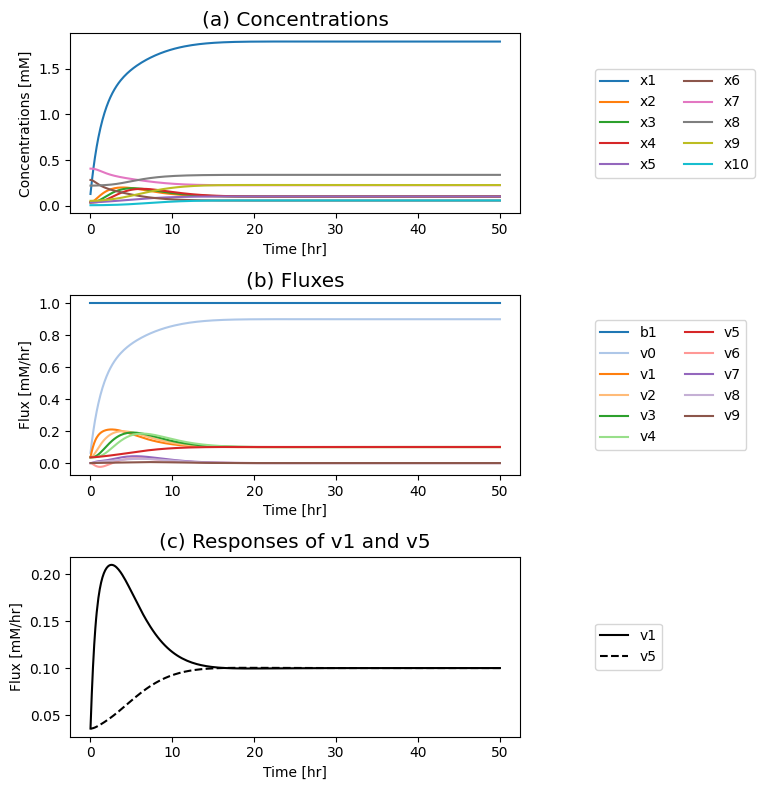

In [58]:
fig_9_19, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    xlabel="Time [hr]", ylabel="Concentrations [mM]", 
    title=("(a) Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(b) Fluxes", XL_FONT));

plot_time_profile(
    flux_sol, observable=["v1", "v5"], ax=ax3, 
    legend="right outside",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("(c) Responses of v1 and v5", XL_FONT),
    color="black", linestyle=["-", "--"]);
fig_9_19.tight_layout()

**Figure 9.19:** Simulation of the tetrameric system where the influx of $b_1$ is varied. (a) The concentration profiles. (b) The flux profiles. (c) Comparison of the flux into $(v_1)$ and out of $(v_5)$  the reaction sequence.

Compare the performance of the unregulated, monomer, dimer, and tetramer systems to reject the disturbance in the input flux.

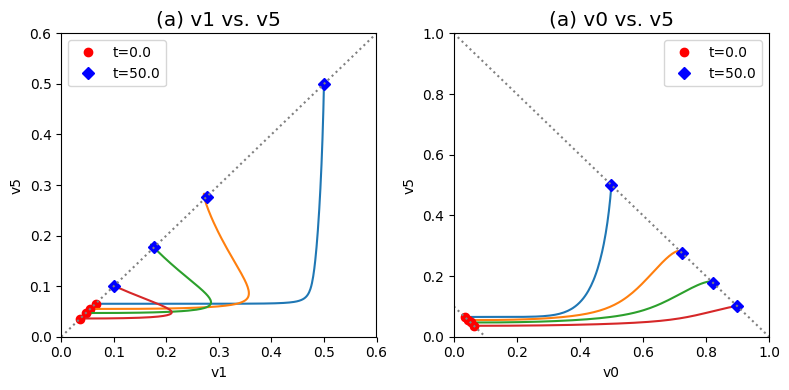

In [59]:
fig_9_20, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
(ax1, ax2) = axes.flatten()

for model, sim in zip(models, simulations):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict)

    # Plot v1 vs. v5
    plot_phase_portrait(
        flux_sol, x="v1", y="v5", ax=ax1,
        xlim=(0, 0.6), ylim=(0, 0.6),
        xlabel="v1", ylabel="v5",
        title=("(a) v1 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

    # Plot v0 vs. v5
    plot_phase_portrait(
        flux_sol, x="v0", y="v5", ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(0, 1), ylim=(0, 1),
        xlabel="v0", ylabel="v5", 
        title=("(a) v0 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_legend="best");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_20.tight_layout()

**Figure 9.20:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$.The model is the simple feedback loop for the same conditions as in Figure 9.9 except for the dimeric and tetrameric forms of the inhibition mechanism. The red points are at the start time and the blue points are at the final time.


#### Pool sizes and their states: tetramer model
The fraction of the enzyme that is in the inhibited form can be computed for the tetramer:

$$\begin{equation} f_{inhibited} = \frac{x_7 + x_8 + x_9 + x_{10}}{x_2 + x_6 + x_7 + x_8 + x_9 + x_{10}} \tag{9.11} \end{equation}$$

Therefore the fraction of free enzyme can be computed for the dimer:

$$\begin{equation} f_{free} = \frac{x_2 + x_6}{x_2 + x_6 + x_7 + x_8 + x_9 + x_{10}} \tag{9.12} \end{equation}$$


We can also look at the fractions of occupied and unoccupied inhibitor sites for the tetramer:

$$\begin{equation} f_{occupied} = \frac{x_7 + 2x_8 + 3x_9 + 4x_{10}}{4(x_2 + x_6 + x_7 + x_8 + x_9 + x_{10})} \tag{9.13} \end{equation}$$

Therefore the fraction of unoccupied enzyme can be computed for the dimer:

$$\begin{equation} f_{unoccupied} = \frac{4x_2 + 4x_6 + 3x_7 + 2x_8 + x_9}{4(x_2 + x_6 + x_7 + x_8)} \tag{9.14} \end{equation}$$

Again, the increased number of binding sites for $x_5$ on the enzyme $(x_6)$ increases the efficacy of the regulatory mechanisms on the ability of the system to reject the disturbance imposed on it. 

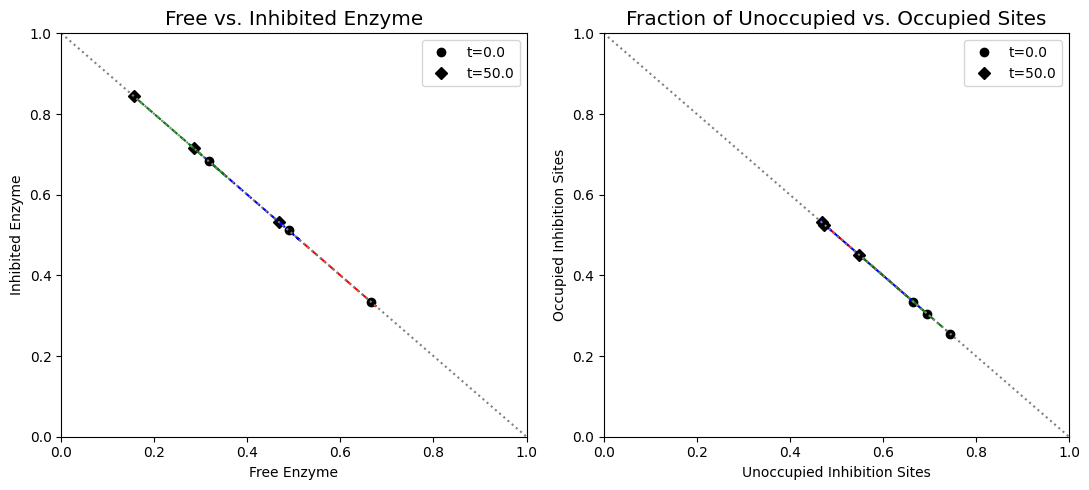

In [60]:
tetramer_pools = {
    "Free": "x2 + x6",
    "Inhibited": "x7 + x8 + x9 + x10",
    "Fraction_Unoccupied": "(4*x2 + 4*x6 + 3*x7 + 2*x8 + x9) / 4*(x2 + x6 + x7 + x8 + x9 + x10)",
    "Fraction_Occupied": "(x7 + 2*x8 + 3*x9 + 4*x10) / 4*(x2 + x6 + x7 + x8 + x9 + x10)" ,
}

enzyme_pools = {
    "Monomer": monomer_pools,
    "Dimer": dimer_pools,
    "Tetramer": tetramer_pools,
}

colors = ["red", "blue", "green"]

fig_9_21,  axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
ax1, ax2 = axes.flatten()

for i, (model, sim) in enumerate(zip(models[1:], simulations[1:])):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict)
    
    pools = enzyme_pools[model.id]
    for pool_id, equation in pools.items():
        conc_sol.make_aggregate_solution(pool_id, equation)
    
    plot_phase_portrait(
        conc_sol, x="Free", y="Inhibited", ax=ax1,
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
        color=colors[i], linestyle=["--"],
        title=("Free vs. Inhibited Enzyme", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="best")

    plot_phase_portrait(
        conc_sol, x="Fraction_Unoccupied", y="Fraction_Occupied", ax=ax2,
        legend=([model.id], "right outside"), 
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Unoccupied Inhibition Sites", ylabel="Occupied Inhibition Sites",
        color=colors[i], linestyle=["--"],
        title=("Fraction of Unoccupied vs. Occupied Sites", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="best")


# Add line representing the constant enzyme 
ax1.plot([0, 1], [1, 0], color="grey", linestyle=":");
ax2.plot([0, 1], [1, 0], color="grey", linestyle=":");
fig_9_21.tight_layout()

**Figure 9.21:** (a) Dynamic phase portrait of inhibited enzyme vs. free enzyme for the monomer, dimer and tetramer. (b) Dynamic phase portrait of the fraction of occupied inhibitor sites vs. the fraction of unoccupied enzyme for the monomer, dimer and tetramer. 

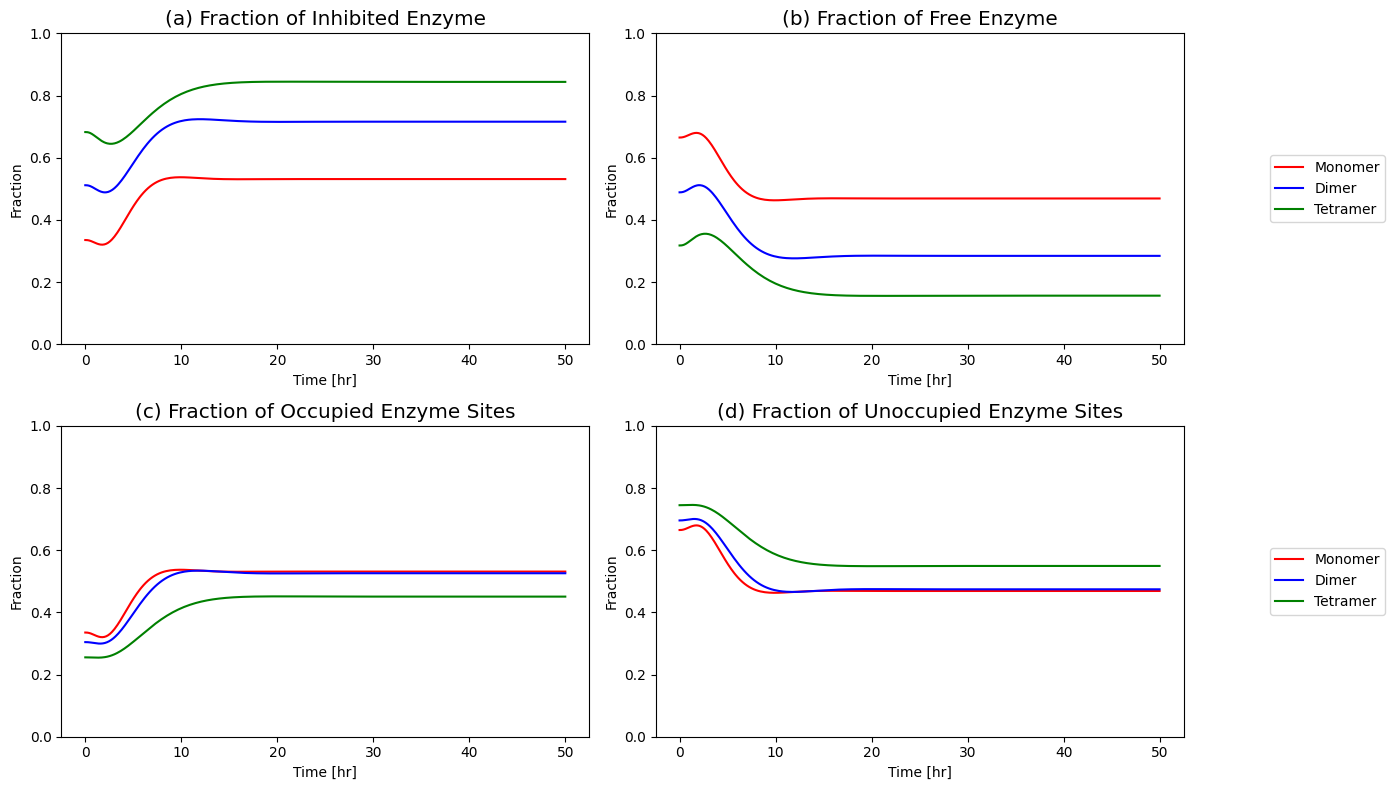

In [61]:
fig_9_22, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), )
(ax1, ax2, ax3, ax4) = axes.flatten()

for i, (model, sim) in enumerate(zip(models[1:], simulations[1:])):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    # Make Fraction of Free Enzyme pool
    conc_sol.make_aggregate_solution(
        "Fraction_Free", equation="{0} / ({0} + {1})".format("Free", "Inhibited"),
        variables=["Free", "Inhibited"])
    # Make Fraction of Inhibited Enzyme pool
    conc_sol.make_aggregate_solution(
        "Fraction_Inhibited", equation="{1} / ({0} + {1})".format("Free", "Inhibited"),
        variables=["Free", "Inhibited"])
    
    plot_time_profile(
        conc_sol, observable="Fraction_Inhibited", ax=ax1, 
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(a) Fraction of Inhibited Enzyme", XL_FONT),
        color=colors[i])

    plot_time_profile(
        conc_sol, observable="Fraction_Free", ax=ax2, 
        legend=(model.id, "right outside"),
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(b) Fraction of Free Enzyme", XL_FONT),
        color=colors[i])
    
    plot_time_profile(
        conc_sol, observable="Fraction_Occupied", ax=ax3, 
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(c) Fraction of Occupied Enzyme Sites", XL_FONT),
        color=colors[i])

    plot_time_profile(
        conc_sol, observable="Fraction_Unoccupied", ax=ax4, 
        legend=(model.id, "right outside"),
        ylim=(0, 1), xlabel="Time [hr]", ylabel="Fraction",
        title=("(d) Fraction of Unoccupied Enzyme Sites", XL_FONT),
        color=colors[i])
fig_9_22.tight_layout()

**Figure 9.22:** Fraction of free enzyme and fraction of inhibited enzyme over time for the monomer, dimer, and tetramer models.

#### Breaking down the steady states into the pathway vectors: tetramer model
We can study the steady state solutions by breaking them down into a linear combination of the two pathway vectors in the null space.

In [62]:
tetramer_ss_perturbed = sim.find_steady_state(
    tetramer, strategy="simulate", perturbations=perturbation_dict)

unperturbed = [round(value,3) for value in tetramer_ss[1].values()]
perturbed = [round(value,3) for value in tetramer_ss_perturbed[1].values()]

pd.DataFrame(
    np.vstack((ns.T, unperturbed, perturbed)), 
    index=["Nullspace Path 1", "Nullspace Path 2", "Unperturbed fluxes", "Perturbed fluxes"], 
    columns=[rxn.id for rxn in tetramer.reactions],
    dtype=np.float64)

,b1,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
Nullspace Path 1,1.0,0.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0
Nullspace Path 2,1.0,1.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
Unperturbed fluxes,0.1,0.064,0.036,0.036,0.036,0.036,0.036,0.0,-0.0,0.0,0.0
Perturbed fluxes,1.0,0.900,0.100,0.100,0.100,0.100,0.100,0.0,0.0,-0.0,0.0


The overall flux balance is $b_1 = v_0 + v_5$. Thus, the first pathway goes from 48% of $b_1$ to 81% of $b_1$ after the perturbation and the second pathway goes from a 52% of $b_1$ to 19% of $b_1$ after the perturbation. So the tetramer is more effective in preventing flux from going down the biosynthetic pathway as compared to the monomer and the dimer. 

**A numerical QC/QA:** The loadings on $v_0$ and $v_5$ should add up to $b_1$: 

In [63]:
before = tetramer_ss[1]["v0"] +\
         tetramer_ss[1]["v5"] == tetramer_ss[1]["b1"]
after = tetramer_ss_perturbed[1]["v0"] +\
        tetramer_ss_perturbed[1]["v5"] == tetramer_ss_perturbed[1]["b1"]

pd.DataFrame([before, after],
             index=["Before Perturbation", "After Perturbation"],
             columns=["Add up to b1?"])

,Add up to b1?
Before Perturbation,True
After Perturbation,True


## Regulated Protein Synthesis of the Regulatory Enzyme
In this section, we will look at the effects of regulating protein synthesis on the basic Monomer model. We will do this by comparing the Monomer model without the protein synthesis and degradation reactions to the monomer model with the synthesis and degradation reactions. We will then add the synthesis and degradation reactions to the unregulated, dimeric and tetrameric models and perform dynamic simulations to examine the differences in disturbance rejection among the models. 

### Regulation of Protein Synthesis
In the feedback loop, $x_5$ feedback inhibits its own synthesis by transforming the first enzyme in the reaction chain into an inactive form. In many organisms, end products like $x_5$ can also feedback regulate the synthesis rate of the enzyme itself and thus regulate the total amount of enzyme present. Thus, $e_t$ is no longer a constant but a dynamic variable. This regulation of protein synthesis can be simulated by adding a synthesis and degradation rate in the dynamic equation for the enzyme, $x_6$, where we can use an inhibition rate of the Hill form with $\nu = 1:$

$$\begin{equation} v_{10} = \frac{k_{10}}{1 + K_{10}x_5} \tag{9.8} \end{equation}$$

and a first order turnover 

$$\begin{equation} v_{11} = k_{11}x_6 \tag{9.9} \end{equation}$$

for the enzyme. Note that these equations assume that the inhibited form, $x_7$, is stable. 

#### Updating the model
Define synthesis and degradation reactions for $x_6$ and add them to the model (resulting in a new model). Define a Hill type inhibition rate for the synthesis reaction (no need to define a custom rate equation for the degradation reaction). The final product $(x_5)$ acts hereby as the inhibitor. A parameter set is chosen that preserves the steady initial state of the initial model. If we pick $k_{11} = 0.1$, we can solve for the other parameters so the network will have the same initial state as in the initial model, and the protein turnover will have a time constant of 10 (=1/0.1).  Macromolecular turnover is much slower than metabolite turnover.

Visualize the difference between the initial and the extended model:

![Figure-9-23](../images/Ch9/Figure-9-23.png)

**Figure 9.23:** Visual representation of the monomer with protein synthesis and degradation for a biosynthetic pathway. The red pathway in the model from the inclusion the of the protein synthesis and degradation reactions.

In [64]:
monomer_w_synth = monomer.copy()
monomer_w_synth.id += "_with_Synthesis"

mets = monomer_w_synth.metabolites
# Define synthesis
v10 = MassReaction("v10")
v10.add_metabolites({mets.x6: 1})

# Define drain
v11 = MassReaction("v11", reversible=False)
v11.add_metabolites({mets.x6: -1})
v11.kf = 0.1

monomer_w_synth.add_reactions([v10, v11])
monomer_w_synth.add_custom_rate(v10, custom_rate="{0} / (1 + {1}*x5(t))".format(v10.kf_str, v10.Keq_str))

To get the parameters for the steady state system, we use the parameters from above and simulate to very long times to obtain the steady state concentrations. Since we will substitute these values into sympy equations in the next step, we will also ensure that the metabolites are represented as **sympy.Symbol** objects.

In [65]:
ics = {sym.Symbol(met): ic_value
       for met, ic_value in sim_monomer.find_steady_state(
           monomer, strategy="simulate")[0].items()}
for metabolite, ic in ics.items():
    print("%s: %s" % (metabolite, ic))

x1: 0.09009804864071885
x2: 0.05495097567964058
x3: 0.05495097567964058
x4: 0.05495097567964058
x5: 0.05495097567964058
x6: 0.6099019513593114
x7: 0.3351470729611085


We then set the rate equations for the protein synthesis and degradation equal to each other. We also set the quantity of $K_{10}x_{5}$ equal to 10 since we want a protein turnover time constant of 10, and the rate law seen in Eq. (9.9) represents the synthesis rate. 

In [66]:
# Set up symbolic equalities using sympy
eq1 = sym.Eq(10, sym.Symbol(v10.Keq_str)*sym.Symbol("x5"))
sym.pprint(eq1)

eq2 = sym.Eq(strip_time(monomer_w_synth.custom_rates[v10]),
             strip_time(strip_time(monomer_w_synth.rates[v11])))
sym.pprint(eq2)

10 = Keqᵥ₁₀⋅x₅
    kfᵥ₁₀               
───────────── = kfᵥ₁₁⋅x₆
Keqᵥ₁₀⋅x₅ + 1           


We solve the  equations using the steady state conditions for $K_{10}$ and then for $k_{10}$:

In [67]:
# Substitute ics and obtain Keq for v10
sym.pprint(eq1.subs(ics))

#Update model with new parameter value
v10.Keq = float(sym.solve(eq1.subs(ics))[0])
print("{0} = {1:.3f}\n".format(v10.Keq_str, v10.Keq))

# Susbtitute ics and Keq for v10, and kf for v11 to obtain kf for v10
parameters = {
    sym.Symbol(v10.Keq_str): v10.Keq,
    sym.Symbol(v11.kf_str): v11.kf}
sym.pprint(eq2.subs(ics).subs(parameters))

#Update model with new parameter value
v10.kf = float(sym.solve(eq2.subs(ics).subs(parameters))[0])
print("{0} = {1:.3f}\n".format(v10.kf_str, v10.kf))

10 = 0.0549509756796406⋅Keqᵥ₁₀
Keq_v10 = 181.980

0.0909090909090909⋅kfᵥ₁₀ = 0.0609901951359311
kf_v10 = 0.671



#### Dynamic states: protein synthesis
The effect of this additional process can be simulated. The stability of the enzyme $(k_{11} = 0.10)$ introduces a slower secondary response of this loop. During this secondary response, the total enzyme concentration drops from 1.0 to a value of 0.748428, (Figure 9.24a) During this slow response, the concentration of $x_1$ rises due to a lower flux into the reaction chain $(v_2)$ and the end product $(x_5)$ drops slightly,  (Figure 9.24b).

In [68]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 300)
sim_monomer_synth = Simulation(monomer_w_synth)

# Place models and simulations into lists for later
models_with_synth = [monomer_w_synth]
simulations_with_synth = [sim_monomer_synth]

for model, sim in zip([monomer, monomer_w_synth],
                      [sim_monomer, sim_monomer_synth]):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict);

    conc_sol.make_aggregate_solution(
        "Total_Enzyme", equation="x2 + x6 + x7",
        variables=["x2", "x6", "x7"]);

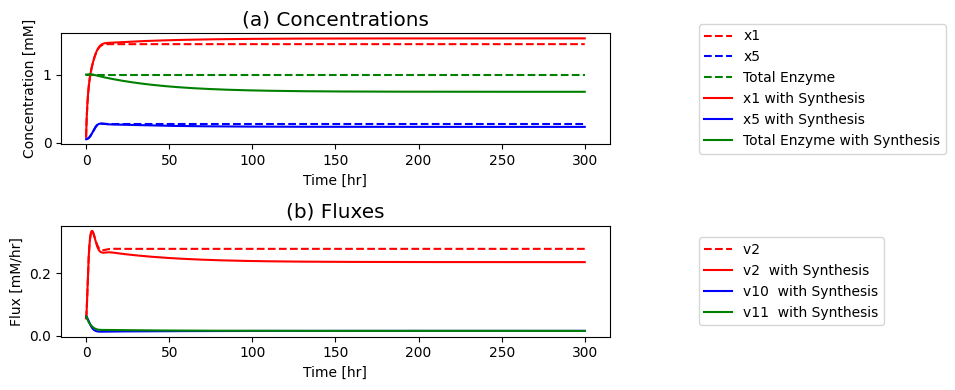

In [69]:
fig_9_24, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), 
                              )
(ax1, ax2) = axes.flatten()

synthesis_strs = ["", " with Synthesis"]
linestyles = ["--", "-"]
colors = ["red", "blue", "green"]
observable_fluxes = [["v2"], ["v2", "v10", "v11"]]


for i, (model, sim) in enumerate(zip([monomer, monomer_w_synth],
                                     [sim_monomer, sim_monomer_synth])):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))

    plot_time_profile(
        conc_sol, observable=["x1", "x5"], ax=ax1,
        legend=(["x1" + synthesis_strs[i], "x5" + synthesis_strs[i]],
                "right outside"),
        color=colors[:2], linestyle=linestyles[i]);
    
    plot_time_profile(
        conc_sol, observable=["Total_Enzyme"], ax=ax1,
        legend=(["Total Enzyme" + synthesis_strs[i]], "right outside"),
        xlabel="Time [hr]", ylabel="Concentration [mM]",
        title=("(a) Concentrations", XL_FONT),
        color=colors[2:], linestyle=linestyles[i]);
    
    plot_time_profile(
        flux_sol, observable=observable_fluxes[i], ax=ax2,
        legend=([entry + " " + synthesis_strs[i]
                 for entry in observable_fluxes[i]],
                "right outside"),
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        title=("(b) Fluxes", XL_FONT),
        color=colors[:2*i + 1], linestyle=linestyles[i]);
fig_9_24.tight_layout()

**Figure 9.24:** The time profiles for concentrations and fluxes involved in the monomer model with feedback control of protein synthesis. The parameter values used are $k_{10}=0.671,\ K_{10} =182,$ and $k_{11} = 0.10$. Other parameter values are as in Figure 9.8.(a) Key concentrations as a function of time for the monomer model with and without the protein synthesis. (b) Key reaction fluxes as a function of time for the monomer model with and without the protein synthesis.

#### Slowly changing pool sizes: protein synthesis

These changes can also be traced out using dynamic phase portraits, see Figure 9.25. Compared to the response without the regulation of protein synthesis (Figure 9.10a) the input and output rates from the reaction chain drop slowly. This motion is approximately along the 45 degree line. The phase portrait of the free and inhibited forms of the enzyme $x_2 + x_6$ and $x_7$ initially follows the straight line $x_2 + x_6 + x_7 = X,$ as without the control of enzyme synthesis but then has a secondary slow response where the total amount of the enzyme drops from X to about Y. Thus, the control of enzyme synthesis drops the total amount of the enzyme by about $40\%$, leading to a lower flux through $v_2$.

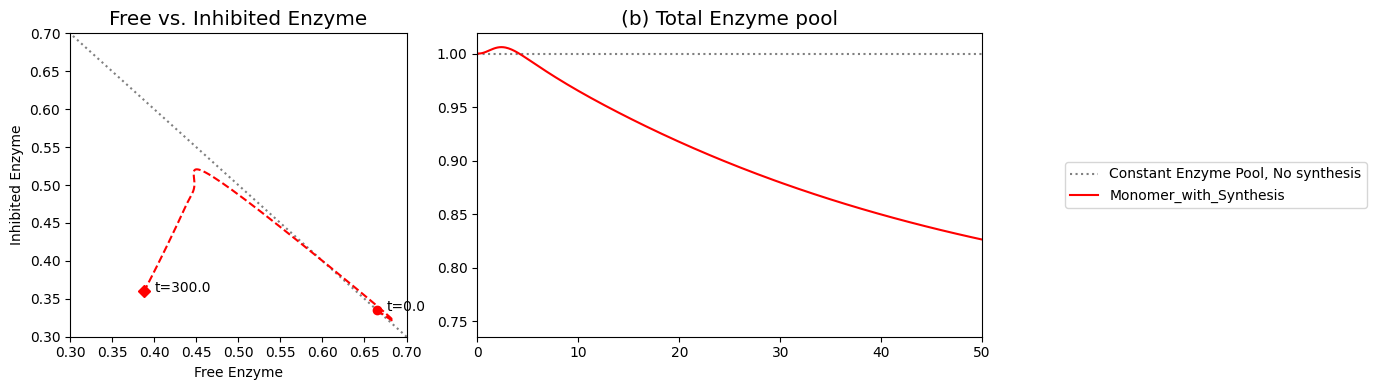

In [70]:
fig_9_25 = plt.figure(figsize=(14, 4))
gs = fig_9_25.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_9_25.add_subplot(gs[0, 0])
ax2 = fig_9_25.add_subplot(gs[0, 1])

# Annotate line representing constant enzyme on plots
ax1.plot([0, 1], [1, 0], color="grey", linestyle=":")
ax2.plot([t0, tf], [1, 1], color="grey", linestyle=":", 
         label="Constant Enzyme Pool, No synthesis");
ax2.legend()

enzyme_pools = {
    "Free": ["x2 + x6", ["x2", "x6"]],
    "Monomer_with_Synthesis_Inhibited": ["x7", ["x7"]]}
for pool_id, args in enzyme_pools.items():
    equation, variables = args
    conc_sol.make_aggregate_solution(
        pool_id, equation, variables)

plot_phase_portrait(
    conc_sol, x="Free", y=monomer_w_synth.id + "_Inhibited", ax=ax1,
    xlim=(0.3, .7), ylim=(0.3, .7),
    xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
    color=["red"], linestyle=["--"],
    title=("Free vs. Inhibited Enzyme", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_color=["red"],
    annotate_time_points_labels=True)

plot_time_profile(
    conc_sol, observable=["Total_Enzyme"], ax=ax2,
    legend=([monomer_w_synth.id], "right outside"),
    xlim=(t0, 50), color="red",
    title=("(b) Total Enzyme pool", XL_FONT));
fig_9_25.tight_layout()

**Figure 9.25:** (a) Dynamic phase portrait of the inhibited enzyme vs. the free enzyme for the monomer model with the protein synthesis reactions and (b) the conservation pool over time.

Analyze the effects of the protein synthesis reactions on the models and their ability to reject the disturbance.

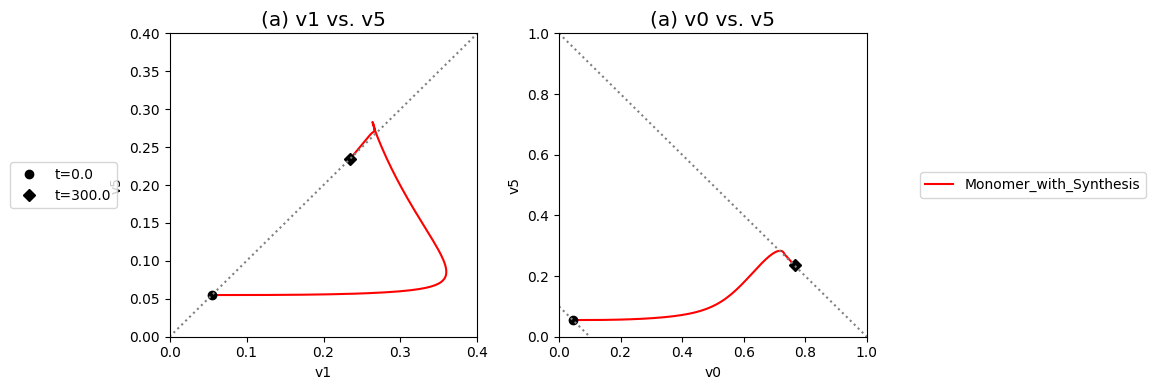

In [71]:
fig_9_26, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
(ax1, ax2) = axes.flatten()

# Plot v1 vs. v5
plot_phase_portrait(
    flux_sol, x="v1", y="v5", ax=ax1,
    xlim=(0, 0.4), ylim=(0, 0.4),
    xlabel="v1", ylabel="v5", color="red",
    title=("(a) v1 vs. v5", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_color="black",
    annotate_time_points_legend="left outside");

# Plot v0 vs. v5
plot_phase_portrait(
    flux_sol, x="v0", y="v5", ax=ax2,
    legend=([model.id], "right outside"),
    xlim=(0, 1), ylim=(0, 1),
    xlabel="v0", ylabel="v5", color="red",
    title=("(a) v0 vs. v5", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_color="black");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_26.tight_layout()

**Figure 9.26:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$. The model is the simple feedback loop for the same conditions as in Figure 9.9 except with the protein synthesis and degradation reactions.

### Dimer With Protein Synthesis
We repeat the process for the dimer model and compare it to the monomer models with and without protein synthesis:

In [72]:
dimer_w_synth = dimer.copy()
dimer_w_synth.id += "_with_Synthesis"

mets = dimer_w_synth.metabolites
# Define synthesis
v10 = MassReaction("v10")
v10.add_metabolites({mets.x6: 1})

# Define drain
v11 = MassReaction("v11", reversible=False)
v11.add_metabolites({mets.x6: -1})
v11.kf = 0.1

dimer_w_synth.add_reactions([v10, v11])
dimer_w_synth.add_custom_rate(
    v10, custom_rate="{0} / (1 + ({1}*x5(t))**2)".format(
        v10.kf_str, v10.Keq_str))

To get the parameters for the steady state system, we use the parameters from above and simulate to very long times to obtain the steady state concentrations. Since we will substitute these values into sympy equations in the next step, we will also ensure that the metabolites are represented as **sympy.Symbol** objects

In [73]:
ics = {sym.Symbol(met): ic_value
       for met, ic_value in sim_dimer.find_steady_state(
           dimer, strategy="simulate")[0].items()}
for metabolite, ic in ics.items():
    print("%s: %s" % (metabolite, ic))

x1: 0.10619608924866035
x2: 0.04690195537566983
x3: 0.04690195537566983
x4: 0.04690195537566983
x5: 0.04690195537566983
x6: 0.4416542615411
x7: 0.4142889693255017
x8: 0.09715481375968464


We then set the rate equations for the protein synthesis and degradation equal to each other. We also set the quantity of $K_{10}x_{5}$ equal to 10 since we want a protein turnover time constant of 10, and the rate law seen in Eq. (9.9) represents the synthesis rate. 

In [74]:
# Set up symbolic equalities using sympy
eq1 = sym.Eq(10, sym.Symbol(v10.Keq_str)*sym.Symbol("x5"))
sym.pprint(eq1)

eq2 = sym.Eq(strip_time(dimer_w_synth.custom_rates[v10]),
             strip_time(strip_time(dimer_w_synth.rates[v11])))
sym.pprint(eq2)

10 = Keqᵥ₁₀⋅x₅
     kfᵥ₁₀                
─────────────── = kfᵥ₁₁⋅x₆
      2   2               
Keqᵥ₁₀ ⋅x₅  + 1           


We solve the  equations using the steady state conditions for $K_{10}$ and then for $k_{10}:$

In [75]:
# Substitute ics and obtain Keq for v10
sym.pprint(eq1.subs(ics))

#Update model with new parameter value
v10.Keq = float(sym.solve(eq1.subs(ics))[0])
print("{0} = {1:.3f}\n".format(v10.Keq_str, v10.Keq))

# Susbtitute ics and Keq for v10, and kf for v11 to obtain kf for v10
parameters = {sym.Symbol(v10.Keq_str): v10.Keq, sym.Symbol(v11.kf_str): v11.kf}
sym.pprint(eq2.subs(ics).subs(parameters))

#Update model with new parameter value
v10.kf = float(sym.solve(eq2.subs(ics).subs(parameters))[0])
print("{0} = {1:.3f}\n".format(v10.kf_str, v10.kf))


10 = 0.0469019553756698⋅Keqᵥ₁₀
Keq_v10 = 213.211

0.00990099009900989⋅kfᵥ₁₀ = 0.04416542615411
kf_v10 = 4.461



#### Dynamic states: dimer model protein synthesis
The effect of this additional process can be simulated and plotted for comparison with the monomer models.

In [76]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 300)
sim_dimer_synth = Simulation(dimer_w_synth)

# Place models and simulations into lists for later
models_with_synth += [dimer_w_synth]
simulations_with_synth += [sim_dimer_synth]

for model, sim in zip([dimer, dimer_w_synth],
                      [sim_dimer, sim_dimer_synth]):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict);

    conc_sol.make_aggregate_solution(
        "Total_Enzyme", equation="x2 + x6 + x7 + x8",
        variables=["x2", "x6", "x7", "x8"]);

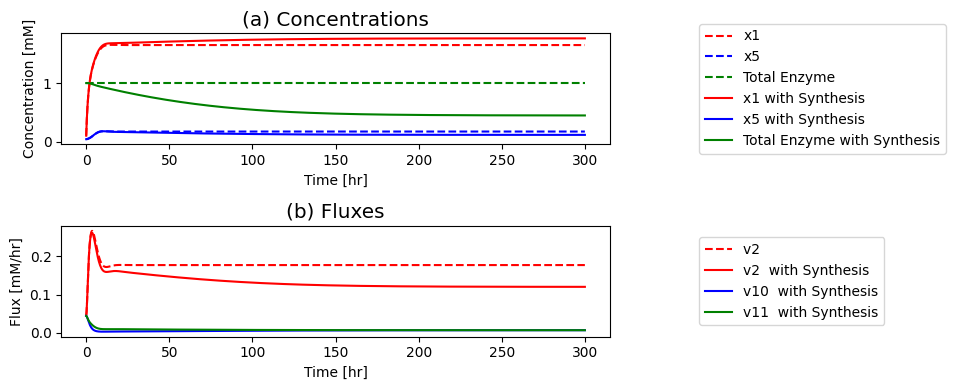

In [77]:
fig_9_27, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
(ax1, ax2) = axes.flatten()

synthesis_strs = ["", " with Synthesis"]
linestyles = ["--", "-"]
colors = ["red", "blue", "green"]
observable_fluxes = [["v2"], ["v2", "v10", "v11"]]


for i, (model, sim) in enumerate(zip([dimer, dimer_w_synth],
                                     [sim_dimer, sim_dimer_synth])):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))

    plot_time_profile(
        conc_sol, observable=["x1", "x5"], ax=ax1,
        legend=(["x1" + synthesis_strs[i], "x5" + synthesis_strs[i]],
                "right outside"),
        color=colors[:2], linestyle=linestyles[i]);
    
    plot_time_profile(
        conc_sol, observable=["Total_Enzyme"], ax=ax1,
        legend=(["Total Enzyme" + synthesis_strs[i]], "right outside"),
        xlabel="Time [hr]", ylabel="Concentration [mM]",
        title=("(a) Concentrations", XL_FONT),
        color=colors[2:], linestyle=linestyles[i]);
    
    plot_time_profile(
        flux_sol, observable=observable_fluxes[i], ax=ax2,
        legend=([entry + " " + synthesis_strs[i]
                 for entry in observable_fluxes[i]],
                "right outside"),
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        title=("(b) Fluxes", XL_FONT),
        color=colors[:2*i + 1], linestyle=linestyles[i]);
fig_9_27.tight_layout()

**Figure 9.27:** The time profiles for concentrations and fluxes involved in the dimer model with feedback control of protein synthesis. The parameter values used are $k_{10}=4.461,\ K_{10} =213,$ and $k_{11} = 0.10.$ Other parameter values are as in Figure 9.8.(a) Key concentrations as a function of time for the monomer model with and without the protein synthesis. (b) Key reaction fluxes as a function of time for the monomer model with and without the protein synthesis.

#### Slowly changing pool sizes: dimer model protein synthesis
Next, we examine the changes in pool size:

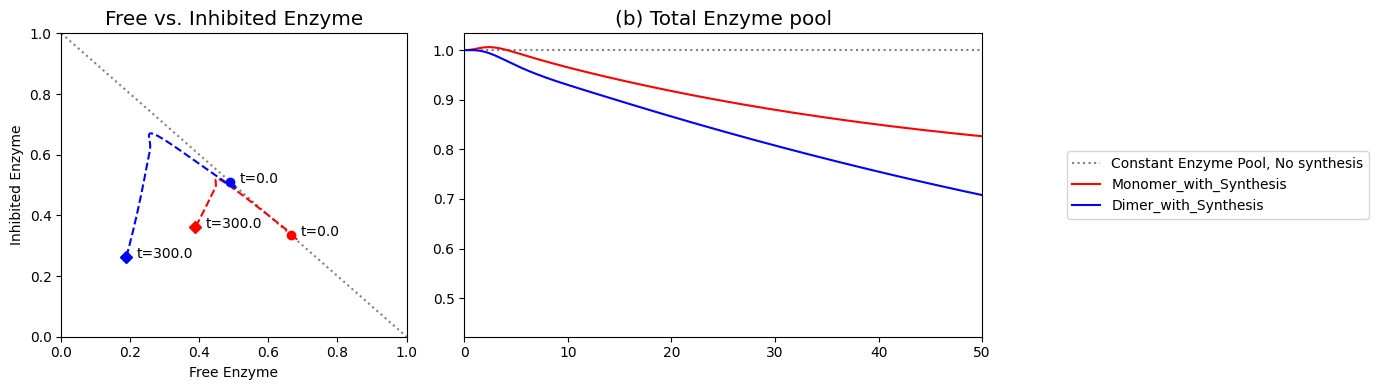

In [78]:
fig_9_28 = plt.figure(figsize=(14, 4))
gs = fig_9_28.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_9_28.add_subplot(gs[0, 0])
ax2 = fig_9_28.add_subplot(gs[0, 1])

# Annotate line representing constant enzyme on plots
ax1.plot([0, 1], [1, 0], color="grey", linestyle=":")
ax2.plot([t0, tf], [1, 1], color="grey", linestyle=":", 
         label="Constant Enzyme Pool, No synthesis");
ax2.legend()

enzyme_pools = {
    "Free": ["x2 + x6", ["x2", "x6"]],
    "Monomer_with_Synthesis_Inhibited": ["x7", ["x7"]],
    "Dimer_with_Synthesis_Inhibited": ["x7 + x8", ["x7", "x8"]]}

colors = ["red", "blue"]

for i, (model, sim) in enumerate(zip(models_with_synth,
                                     simulations_with_synth)):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    for pool_id, args in enzyme_pools.items():
        if pool_id != "Free" and model.id not in pool_id:
            continue
        equation, variables = args
        conc_sol.make_aggregate_solution(
            pool_id, equation, variables)

    plot_phase_portrait(
        conc_sol, x="Free", y=model.id + "_Inhibited", ax=ax1,
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
        color=colors[i], linestyle=["--"],
        title=("Free vs. Inhibited Enzyme", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color=colors[i],
        annotate_time_points_labels=True)

    plot_time_profile(
        conc_sol, observable=["Total_Enzyme"], ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(t0, 50), color=colors[i],
        title=("(b) Total Enzyme pool", XL_FONT));
fig_9_28.tight_layout()

**Figure 9.28:** (a) Dynamic phase portrait of the inhibited enzyme vs. the free enzyme for the monomer and dimer models with the protein synthesis reactions and (b) the conservation pools over time.

Analyze the effects of the protein synthesis reactions on the models and their ability to reject the disturbance.

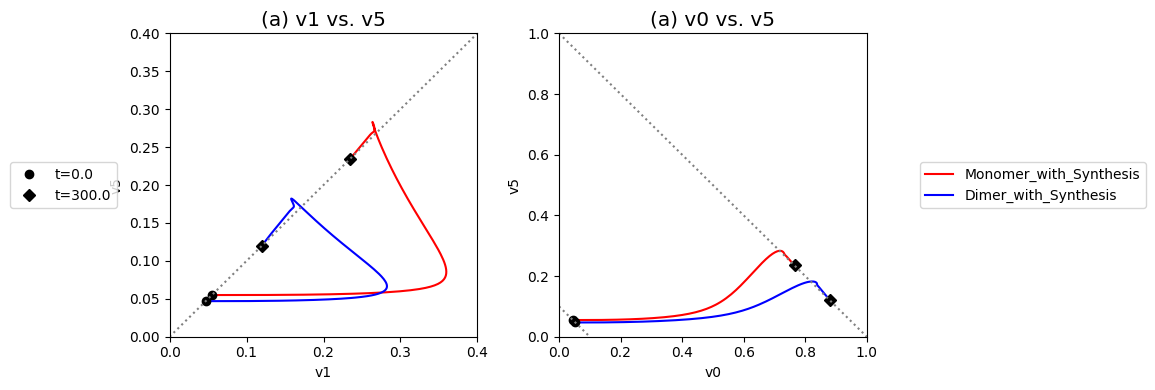

In [79]:
fig_9_29, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
(ax1, ax2) = axes.flatten()
colors = ["red", "blue"]
for i, (model, sim) in enumerate(zip(models_with_synth,
                                     simulations_with_synth)):
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))
    
    # Plot v1 vs. v5
    plot_phase_portrait(
        flux_sol, x="v1", y="v5", ax=ax1,
        xlim=(0, 0.4), ylim=(0, 0.4),
        xlabel="v1", ylabel="v5", color=colors[i],
        title=("(a) v1 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="left outside");

    # Plot v0 vs. v5
    plot_phase_portrait(
        flux_sol, x="v0", y="v5", ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(0, 1), ylim=(0, 1),
        xlabel="v0", ylabel="v5", color=colors[i],
        title=("(a) v0 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_29.tight_layout()

**Figure 9.29:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$. The model is the simple feedback loop for the same conditions as in Figure 9.14 except with the protein synthesis and degradation reactions.

### Tetramer With Protein Synthesis
We repeat the process for the tetramer model and compare it to the monomer and dimer models with and without protein synthesis:

In [80]:
tetramer_w_synth = tetramer.copy()
tetramer_w_synth.id += "_with_Synthesis"

mets = tetramer_w_synth.metabolites
# Define synthesis
v10 = MassReaction("v10")
v10.add_metabolites({mets.x6: 1})

# Define drain
v11 = MassReaction("v11", reversible=False)
v11.add_metabolites({mets.x6: -1})
v11.kf = 0.1

tetramer_w_synth.add_reactions([v10, v11])
tetramer_w_synth.add_custom_rate(
    v10, custom_rate="{0} / (1 + ({1}*x5(t))**4)".format(
        v10.kf_str, v10.Keq_str))

To get the parameters for the steady state system, we use the parameters from above and simulate to very long times to obtain the steady state concentrations. Since we will substitute these values into sympy equations in the next step, we will also ensure that the metabolites are represented as **sympy.Symbol** objects.

In [81]:
ics = {sym.Symbol(met): ic_value
       for met, ic_value in sim_tetramer.find_steady_state(
           tetramer, strategy="simulate")[0].items()}
for metabolite, ic in ics.items():
    print("%s: %s" % (metabolite, ic))

x1: 0.12794830761727488
x2: 0.03602584619136257
x3: 0.03602584619136257
x4: 0.03602584619136258
x5: 0.03602584619136258
x6: 0.2815656327329066
x7: 0.405745607104375
x8: 0.21925993251544862
x9: 0.05266016403153394
x10: 0.004742817424529913


We then set the rate equations for the protein synthesis and degradation equal to each other. We also set the quantity of $K_{10}x_{5}$ equal to 10 since we want a protein turnover time constant of 10, and the rate law seen in Eq. (9.9) represents the synthesis rate. 

In [82]:
# Set up symbolic equalities using sympy
eq1 = sym.Eq(10, sym.Symbol(v10.Keq_str)*sym.Symbol("x5"))
sym.pprint(eq1)

eq2 = sym.Eq(strip_time(tetramer_w_synth.custom_rates[v10]),
             strip_time(strip_time(tetramer_w_synth.rates[v11])))
sym.pprint(eq2)


10 = Keqᵥ₁₀⋅x₅
     kfᵥ₁₀                
─────────────── = kfᵥ₁₁⋅x₆
      4   4               
Keqᵥ₁₀ ⋅x₅  + 1           


We solve the  equations using the steady state conditions for $K_{10}$ and then for $k_{10}:$

In [83]:
# Substitute ics and obtain Keq for v10
sym.pprint(eq1.subs(ics))

#Update model with new parameter value
v10.Keq = float(sym.solve(eq1.subs(ics))[0])
print("{0} = {1:.3f}\n".format(v10.Keq_str, v10.Keq))

# Susbtitute ics and Keq for v10, and kf for v11 to obtain kf for v10
parameters = {sym.Symbol(v10.Keq_str): v10.Keq, sym.Symbol(v11.kf_str): v11.kf}
sym.pprint(eq2.subs(ics).subs(parameters))

#Update model with new parameter value
v10.kf = float(sym.solve(eq2.subs(ics).subs(parameters))[0])
print("{0} = {1:.3f}\n".format(v10.kf_str, v10.kf))

10 = 0.0360258461913626⋅Keqᵥ₁₀
Keq_v10 = 277.578

9.99900009999003e-5⋅kfᵥ₁₀ = 0.0281565632732907
kf_v10 = 281.594



#### Dynamic states: tetramer model protein synthesis
The effect of this additional process can be simulated and plotted for comparison with the monomer models.

In [84]:
scalar = 10
perturbation_dict = {"kf_b1": "kf_b1 * {0}".format(scalar)}

t0, tf = (0, 300)
sim_tetramer_synth = Simulation(tetramer_w_synth)

# Place models and simulations into lists for later
models_with_synth += [tetramer_w_synth]
simulations_with_synth += [sim_tetramer_synth]

for model, sim in zip([tetramer, tetramer_w_synth],
                      [sim_tetramer, sim_tetramer_synth]):
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf),
        perturbations=perturbation_dict);

    conc_sol.make_aggregate_solution(
        "Total_Enzyme", equation="x2 + x6 + x7 + x8 + x9 + x10",
        variables=["x2", "x6", "x7", "x8", "x9", "x10"]);

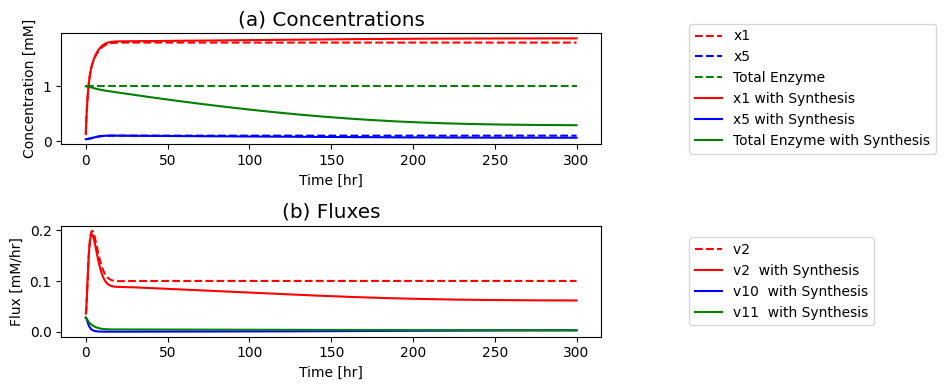

In [85]:
fig_9_30, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
(ax1, ax2) = axes.flatten()

synthesis_strs = ["", " with Synthesis"]
linestyles = ["--", "-"]
colors = ["red", "blue", "green"]
observable_fluxes = [["v2"], ["v2", "v10", "v11"]]


for i, (model, sim) in enumerate(zip([tetramer, tetramer_w_synth],
                                     [sim_tetramer, sim_tetramer_synth])):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))

    plot_time_profile(
        conc_sol, observable=["x1", "x5"], ax=ax1,
        legend=(["x1" + synthesis_strs[i], "x5" + synthesis_strs[i]],
                "right outside"),
        color=colors[:2], linestyle=linestyles[i]);
    
    plot_time_profile(
        conc_sol, observable=["Total_Enzyme"], ax=ax1,
        legend=(["Total Enzyme" + synthesis_strs[i]], "right outside"),
        xlabel="Time [hr]", ylabel="Concentration [mM]",
        title=("(a) Concentrations", XL_FONT),
        color=colors[2:], linestyle=linestyles[i]);
    
    plot_time_profile(
        flux_sol, observable=observable_fluxes[i], ax=ax2,
        legend=([entry + " " + synthesis_strs[i]
                 for entry in observable_fluxes[i]],
                "right outside"),
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        title=("(b) Fluxes", XL_FONT),
        color=colors[:2*i + 1], linestyle=linestyles[i]);
fig_9_30.tight_layout()

**Figure 9.30:** The time profiles for concentrations and fluxes involved in the dimer model with feedback control of protein synthesis. The parameter values used are $k_{10}=281.594,\ K_{10} =278,$ and $k_{11} = 0.10$. Other parameter values are as in Figure 9.8.(a) Key concentrations as a function of time for the monomer model with and without the protein synthesis. (b) Key reaction fluxes as a function of time for the monomer model with and without the protein synthesis.

#### Slowly changing pool sizes: tetramer model protein synthesis
Next, we examine the changes in pool size:

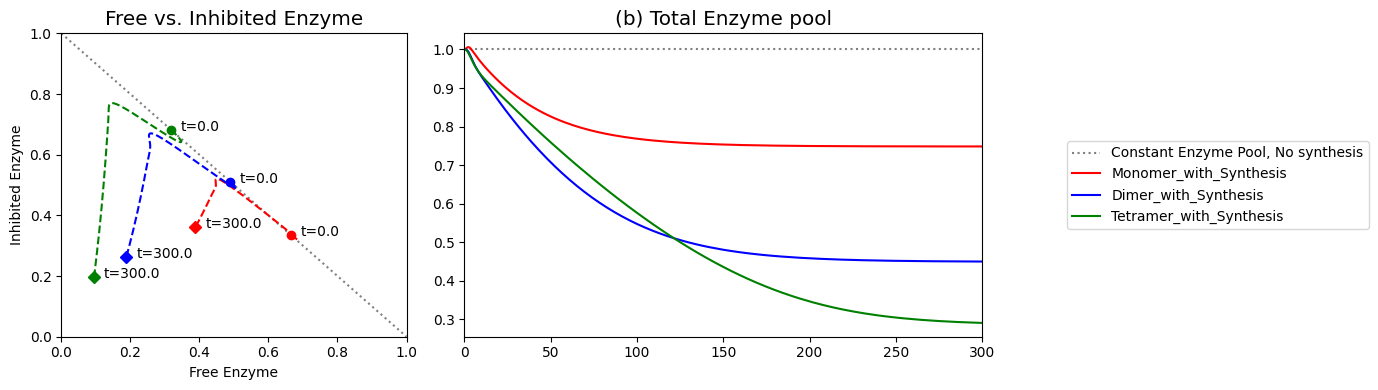

In [86]:
fig_9_31 = plt.figure(figsize=(14, 4))
gs = fig_9_31.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_9_31.add_subplot(gs[0, 0])
ax2 = fig_9_31.add_subplot(gs[0, 1])

# Annotate line representing constant enzyme on plots
ax1.plot([0, 1], [1, 0], color="grey", linestyle=":")
ax2.plot([t0, tf], [1, 1], color="grey", linestyle=":", 
         label="Constant Enzyme Pool, No synthesis");
ax2.legend()

enzyme_pools = {
    "Free": ["x2 + x6", ["x2", "x6"]],
    "Monomer_with_Synthesis_Inhibited": ["x7", ["x7"]],
    "Dimer_with_Synthesis_Inhibited": ["x7 + x8", ["x7", "x8"]],
    "Tetramer_with_Synthesis_Inhibited": [
        "x7 + x8 + x9 + x10", ["x7", "x8", "x9", "x10"]]}

colors = ["red", "blue", "green"]

for i, (model, sim) in enumerate(zip(models_with_synth,
                                     simulations_with_synth)):
    conc_sol = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    for pool_id, args in enzyme_pools.items():
        if pool_id != "Free" and model.id not in pool_id:
            continue
        equation, variables = args
        conc_sol.make_aggregate_solution(
            pool_id, equation, variables)

    plot_phase_portrait(
        conc_sol, x="Free", y=model.id + "_Inhibited", ax=ax1,
        xlim=(0, 1), ylim=(0, 1),
        xlabel="Free Enzyme", ylabel="Inhibited Enzyme",
        color=colors[i], linestyle=["--"],
        title=("Free vs. Inhibited Enzyme", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color=colors[i],
        annotate_time_points_labels=True)

    plot_time_profile(
        conc_sol, observable=["Total_Enzyme"], ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(t0, 300), color=colors[i],
        title=("(b) Total Enzyme pool", XL_FONT));
fig_9_31.tight_layout()

**Figure 9.31:** (a) Dynamic phase portrait of the inhibited enzyme vs. the free enzyme for the monomer, dimer and tetramer models with and without the protein synthesis reactions and (b) the conservation pools over time.

Analyze the effects of the protein synthesis reactions on the models and their ability to reject the disturbance.

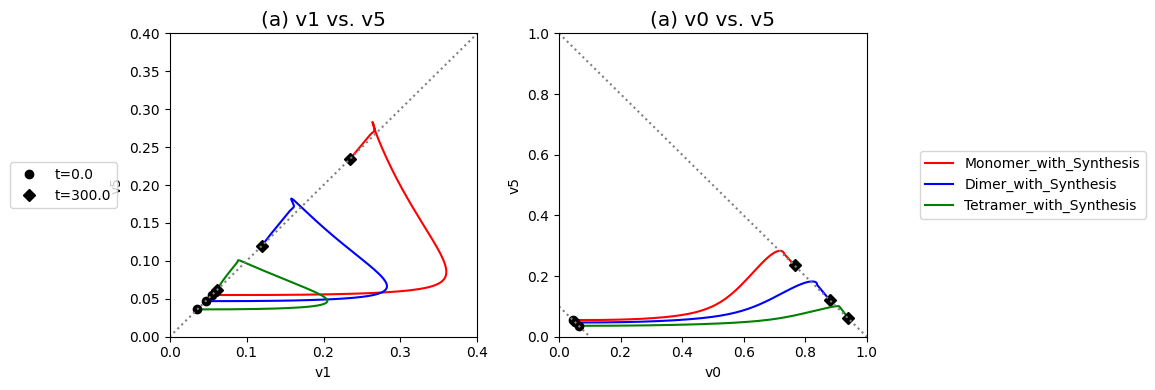

In [87]:
fig_9_32, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
(ax1, ax2) = axes.flatten()
colors = ["red", "blue", "green"]
for i, (model, sim) in enumerate(zip(models_with_synth,
                                     simulations_with_synth)):
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))
    
    # Plot v1 vs. v5
    plot_phase_portrait(
        flux_sol, x="v1", y="v5", ax=ax1,
        xlim=(0, 0.4), ylim=(0, 0.4),
        xlabel="v1", ylabel="v5", color=colors[i],
        title=("(a) v1 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black",
        annotate_time_points_legend="left outside");

    # Plot v0 vs. v5
    plot_phase_portrait(
        flux_sol, x="v0", y="v5", ax=ax2,
        legend=([model.id], "right outside"),
        xlim=(0, 1), ylim=(0, 1),
        xlabel="v0", ylabel="v5", color=colors[i],
        title=("(a) v0 vs. v5", XL_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color="black");

# Annotate steady state line on first plot
ax1.plot([0, 1], [0, 1], color="grey", linestyle=":");

# Annotate flux balance lines on second plot
ax2.plot([0, .1], [.1, 0], color="grey", linestyle=":");
ax2.plot([0, .1*scalar], [.1*scalar, 0], color="grey", linestyle=":");
fig_9_32.tight_layout()

**Figure 9.32:** Dynamic phase portraits for (a) the flux into $(v_1)$ and out of $(v_5)$ in the biosynthetic pathway and (b) the flux out of the primary pathway $(v_0)$ and out of the biosynthetic pathway $(v_5)$. The model is the simple feedback loop for the same conditions as in Figure 9.20 except with the protein synthesis and degradation reactions.

## APPENDIX

This text is about the use of simulation.  We do provide this appendix to introduce the interested reader to the analysis of regulatory phenomena.  We define basics concepts (A.1), the defining role of eigenvalues (A.2) and detailed mathematical analysis of local regulation (A.3).

### A.1 Regulatory Signals: phenomenology    
#### Basic features of a regulatory event:  
The regulatory action of compounds is characterized by three important measures: bias, active range, and sensitivity. These features are illustrated in Figure 9.A1 and are detailed as follows: 

* First, there is a built-in bias; the regulation is either negative (inhibition)  or positive (activation). 


*  Second, there is a range of concentrations over which the signal is active. The measure of this concentration range is the dissociation constant for the regulatory molecule. 


* Third is the sensitivity of the flux to changes in the concentration of the regulator, or the 'gain' of the regulation. 

![Figure-9-A1](../images/Ch9/Figure-9-A1.png)

**Figure 9.A1:** Graphical representation of the three basic features of regulation.

#### Network topology:  
Regulation can be exerted 'close' to the formation of the regulatory molecule, such as feedback activation of an enzyme by its product, or the regulator can be controlling 'far' away from its site formation, as is the case with citrate inhibition of PFK or for amino acids feedback inhibiting the first reaction in the sequence that leads to their formation, see Figure 9.6. 

#### Physiological roles:  
From a network perspective, there are two overall physiological functions of regulatory signals: 

* To overcome any disturbances in the cellular environment. This function is the 'disturbance rejection' problem. A cell or an organism experiences a change in an environmental parameter but wants to maintain its homeostatic state. 

* To drive a network from one state to the next, that is, change the homeostatic state. This need is broad and often encountered from the need to change from a non-growing state to a growing one in response to the availability of a nutrient or to the need for a precursor cell to initiate differentiation to a new state. In control theory, this is known as the 'servo' problem.

### A.2 The Effects of Regulation on Dynamic States  
We now quantitatively assess the effects of regulatory signals on network dynamic states, representing the most mathematically-difficult material in this book. 

#### Basic mathematical features:  
To examine the qualitative effects of signals on network dynamics, let us examine the simple scheme: 

$$\begin{equation} \stackrel{v_1(x)}{\longrightarrow} X \stackrel{v_2(x)}{\longrightarrow} \tag{9.A1} \end{equation}$$

where the concentration of metabolite $X,\ x,$ directly influences the rates of its own formation, $v_1(x),$ and degradation, $v_2(x)$. The following discussion is graphically illustrated in Figure 9.A2. 

The dynamic mass balance on $X$ is 

$$\begin{equation} \frac{dx}{dt} = v_1(x) - v_2(x) \tag{9.A2} \end{equation}$$

that in a linearized form is 

$$\begin{equation} \frac{dx'}{dt} = (\frac{\partial v_1}{\partial x} - \frac{\partial v_2}{\partial x})x' = \lambda x' \tag{9.A3} \end{equation}$$

where $\lambda$ is the 'net' rate constant. The value of $\lambda$ determines the rate of response of this system to changes in the concentration of $X.$ 

#### Measures of systemic effects:  
The quantity, $\lambda$, is a combination of the time constants for the individual reactions. It is thus a 'systems' property rather than a property of a single component or a link in the network. It is equivalent to the eigenvalue of this one-dimensional system. Eigenvalues are systems quantities that are combinations of the properties of the individual components and links. These combinations become complicated as the size of a networks grows. 

![Figure-9-A2](../images/Ch9/Figure-9-A2.png)

**Figure 9.A2:** Qualitative effects of regulatory signals. The graphs show the dependency of flux on the concentration of X.

#### Local regulation:  
We examine the various scenarios that can arise when regulation is added on top of the natural mass action trend: 

* _The unregulated situation:_ When no regulation is exerted, the eigenvalue that describes the dynamics is given by: 

    $$\begin{equation} \lambda = \frac{\partial v_1}{\partial x} - \frac{\partial v_2}{\partial x}' = 0 - k_2 = \lambda^* \lt 0 \tag{9.A4} \end{equation}$$

    if we assume that the turnover rate is first order and the formation rate is zeroth order. The unregulated situation corresponds to elementary mass action kinetics overlaid on the stoichiometric structure. 
    

* _Feedback inhibition:_  If the formation rate is feedback inhibited, the eigenvalue becomes more negative than for the unregulated situation since now $\partial v_1/ \partial x \lt 0$ and hence the time constant is faster. The feedback inhibition therefore augments the mass action trend and supports the natural dynamics of the system. 

* _Feedback activation:_  Feedback activation does just the opposite. Now $\partial v_1/ \partial x \gt 0$ and this signal thus tends to counter the natural dynamics of the system. If the signal is sufficiently strong, then the eigenvalue can become zero or positive, creating an instability that is reflected as multiple steady states. 

* _Feedforward inhibition:_  This signal tends to reduce $\partial v_2/ \partial x$ and hence tends to move $\lambda$ closer to zero making instability more likely. Feedforward inhibition counters the mass action trend and is classified as a destabilizing signal. Note that saturation kinetics are of this type and they are observed to create instabilities in several models (Palsson 1988a, Savageau 1974, Tyson 1983). 

* _Feedforward activation:_  Feedforward activation increases the magnitude of $\lambda$ and thus supports the mass action trend. 


#### Regulatory principles:  
Regulatory signals can either support or antagonize the mass action trend in a network. Thus, we arrive at the following principles: 

$\textbf{1.}$ Local negative feedback and local positive feedforward controls support the mass action trend and are stabilizing in the sense that they try to maintain the intrinsic dynamic properties of the stoichiometric structure. 

$\textbf{2.}$ Local positive feedback and local negative feedforward controls counteract the mass action trend and can create instabilities. Many of the creative functions associated with metabolism can be attributed to these control modes. These signals allow the cell to behave in apparent defiance to the laws of mass action and stoichiometric trends. 

Regulators that act 'far' from their site of formation can induce dynamic instabilities even when the signal supports the mass action trend. There is a limit on the extent of stabilization or support of homeostasis achievable. 

#### Measuring the dynamic effects of regulation  
Equation (9.A4) may be rewritten as 

$$\begin{align}\lambda &= -\frac{\partial v_2}{\partial x}(1 - \frac{\partial v_1/\partial x}{\partial v_2/\partial x}) \tag{9.A5} \\ &\approx  -\frac{\partial v_2}{\partial x}(1 \pm {\frac{t_{turnover}}{t_{regulation}}}) \tag{9.A6} \\ \end{align}$$

if the time constants indicated are good estimates of the corresponding partial derivatives. The dimensionless ratio: 

$$\begin{equation} a = \large{\frac{t_{turnover}}{t_{regulation}}} \tag{9.A7} \end{equation}$$

thus characterizes local regulatory signals. If $a$ is less than unity or on the order of unity, the regulation is dynamically about as important as the natural turnover time. However, if it significantly exceeds unity, one would expect that dynamics then would become dominated by the regulatory action. 

### A.3 Local Regulation with Hill Kinetics    
We will now look at specific examples to quantitatively explore the concepts introduced in the last section. We will use Hill-type rate laws that are the simplest mathematical forms for regulated reactions. Even for the simplest case, the algebra becomes a bit cumbersome. 

#### Inhibition    
We can look quantitatively at the effects of local feedback inhibition. We can consider specific functional forms for $v_1$ and $v_2$ in Eq (9.A2): 

$$\begin{equation} v_1(x) = \frac{v_m}{1 + (x/K)^2}\ \text{and}\ v_2(x) = kx \tag{9.A8} \end{equation}$$

where the production rate is a Hill-type equation with $\nu =2$ and the removal is an elementary first-order equation. The dynamic mass balance is 

$$\begin{equation} \frac{dx}{dt} = \frac{v_m}{1 + (x/K)^2} - kx \tag{9.A9} \end{equation}$$

The dynamics of this simple system can be analyzed to determine the dynamic effects of the feedback inhibition. 

##### The steady state: inhibition
The steady state equation, $v_1 = v_2$, for this network is a cubic equation 

$$\begin{equation} (\frac{x}{K})^3 + \frac{x}{K} - \frac{v_m}{kK} = 0 \tag{9.A10} \end{equation}$$

Introducing a dimensionless concentration $\chi = x/K$ we have that

$$\begin{equation} \chi^3 + \chi - a = 0 \tag{9.A11} \end{equation}$$

where $a=v_m/kK.$ This equation has one real root 

$$\begin{equation} \chi_{ss} = \large{\frac{\sqrt[3]{9a\ +\ \sqrt{3}\sqrt{27a^2\ +\ 4}}}{3\ \sqrt[3]{\frac{2}{3}}} - \frac{\sqrt[3]{\frac{2}{3}}}{\sqrt[3]{9a\ +\ \sqrt{3}\sqrt{27a^2\ +\ 4}}}} \tag{9.A12} \end{equation}$$

The steady state level of $x$, relative to $K$, is dependent on a single parameter, $a$, as shown in Figure 9.A3. We see that 

$$\begin{equation} a = \frac{1/k}{K/v_m} = \frac{t_{turnoever}}{t_{regulation}} \tag{9.A13} \end{equation}$$

##### Determining the eigenvalue: inhibition
By defining $\tau = kt$ we have 

$$\begin{equation} \frac{d\chi}{d\tau} = \frac{a}{1 + \chi^2} - \chi\ \text{and thus}\ \chi_{ss} = \frac{a}{1 + \chi_{ss}^2} \tag{9.A14} \end{equation}$$

The eigenvalue can be computed 

$$\begin{equation} \lambda = \frac{\partial}{d\chi}[\frac{a}{1 + \chi^2} - \chi]_{ss} = \frac{2a \chi_{ss}}{(1 + chi_{ss}^2} - 1 = -\frac{2\chi_{ss}^2}{1 + \chi_{ss}^2} - 1 \tag{9.A15} \end{equation}$$

The eigenvalue thus changes from a negative unity (when $x_{ss} \ll K$ and the regulation is not felt) to a negative three (when $x_{ss} \gg K$ where regulation is strong).

![Figure-9-A3](../images/Ch9/Figure-9-A3.png)

**Figure 9.A3:** Regulation by local feedback inhibition. (a) The dependency of the steady state concentration, $\chi_{ss} = x/K,$ on $a = v_m/kK$ by solving Eq. (9.A11). (b) The eigenvalue as a function of a computed from equation (9.A13).

##### Dynamic simulations: inhibition
The dynamic effects of the feedback regulation can be simulated, Figure 9.A4. Three cases are considered by changing the single dimensionless parameter, $a.$ As $a$ increases, the regulation is tighter and the value of $\lambda$ increases, thus making the approach to steady state faster. 

![Figure-9-A4](../images/Ch9/Figure-9-A4.png)

**Figure 9.A4:** Regulation by local feedback inhibition. The dynamic responses of $d\chi/d\tau = a/(1+\chi^2$ for A): Long dashes: $a = 0.1 (\chi_{ss} = 0.1,\lambda = −1.02).$ B): Short dashes: $a = 1 (\chi_{ss} = 0.68,\ \lambda = −1.64).$ C): Solid line:  $a = 10\ (\chi_{ss} = 2,\lambda = −2.6)$. The initial conditions for each case are $0.9\chi_{ss}$. Each curve is graphed as $\chi(t)/\chi_{ss}.$*

#### Activation
We can look quantitatively at the effects of local feedback activation. We can consider specific functional forms for $v_1$ and $v_2$ in Eq. (9.A2): 

$$\begin{equation} v_1(x) = v_m\frac{1 + \alpha(x/K)^\nu}{1 + (x/K)^\nu}\ \text{and}\ v_2(x) = kx\tag{9.A16} \end{equation}$$

with a dynamic mass balance 

$$\begin{equation} \frac{dx}{dt} =  v_m\frac{1 + \alpha(x/K)^\nu}{1 + (x/K)^\nu} - kx \tag{9.A17} \end{equation}$$

We can make this equation dimensionless using the same dimensionless variables as above 

$$\begin{equation} \frac{d\chi}{d\tau} = a\frac{1 + \alpha\chi^\nu}{1 + \chi^\nu} - \chi \tag{9.A18} \end{equation}$$

##### The steady state: activation
In a steady state, the dynamic mass balance becomes: 

$$\begin{equation} \chi_{ss} = a\frac{1 + \alpha\chi_{ss}^\nu}{1 + \chi_{ss}^\nu}  \tag{9.A19} \end{equation}$$

##### Determining the eigenvalue: activation 
The eigenvalue can be determined by the linearization of Eq. (9.A18) 

$$\begin{equation} \lambda = \frac{\nu a(\alpha - 1)\chi_{ss}^{\nu-1}}{(1+chi_{ss}^\nu)^2} -1 \tag{9.A20} \end{equation}$$

since $\alpha\gt \ 1$, the first term in equation Eq. (9.A20) is positive. This leads to the possibility that the eigenvalue is zero. This condition in turn leads to a situation where one can have multiple steady states as will now be demonstrated. 

##### Existence of multiple steady states
We are looking for conditions where Eqs (9.A19) and (9.A20) are simultaneously zero, that is, the steady state condition and a zero eigenvalue. The two equations can be combined by multiplying Eq. (9.A20) by $\chi$ and adding the equations together. After rearrangement, the equations become 

$$\begin{equation} z^2 + [(1-\nu) + (1+\nu)/\alpha]z + 1/\alpha = 0,\ z=\chi^\nu \tag{9.A21} \end{equation}$$

This equation can only have a real positive solution if 

$$\begin{equation} \alpha \gt \alpha_{min} = \frac{(1 + \nu)}{(1-\nu)}^2 \tag{9.A22} \end{equation}$$

If $\alpha$ exceeds this minimum value, the steady state equation will have multiple solutions for $\chi$ for a range of values for $a.$ 

#### Region of multiple steady states in the parameter plane  
If $\alpha$ exceeds its minimum value, multiple steady states are possible. Equation (9.A21) will have two roots, $\chi_{1, ss}$ and $\chi_{2, ss}.$ These roots depend on two parameters, $a$ and $\alpha.$ To compute the relationships between $a$ and $\alpha.$  when the eigenvalue is zero, we can first specify $\alpha$ and compute $\chi_{1, ss}$ and $\chi_{2, ss}$ and then compute the two corresponding values for $a_1$ and $a_2$: 

$$\begin{equation} a_1 = \chi_{1, ss}(\frac{1 + \chi_{1, ss}^\nu}{1 + \alpha \chi_{1, ss}^\nu}) \tag{9.A23} \end{equation}$$

and the same for $a_2$ as a function of $\chi_{2, ss}$. The results are shown in Figure 9.A5a. 

##### Computing the multiple steady state values for the steady state concentration  
For a fixed value of $\alpha$ we can vary $a$ along a line in the parameter plane and compute the steady state concentration. Since one cannot solve the steady state solution explicitly for $\chi_{ss},$ this is hard to do; however, one can rearrange it as 

$$\begin{equation} a = \chi_{1, ss}(\frac{1 + \chi_{ss}^\nu}{1 + \alpha \chi_{ss}^\nu}) \tag{9.A24} \end{equation}$$

and plot $a$ versus $\chi_{ss}$ to get the same results. The limit, or turnaround point, corresponds to substituting the roots of Eq (9.A21)  into Eq (9.A24). The resulting graphs are shown in Figure 9.A5b. Similarly, one can fix a and compute the relationship between $\chi_{ss}$ and $\alpha,$ see Figure 9.A5c. 

##### Simulating the dynamic response to a critical change in the parameter values  
We can simulate the dynamic response of this loop to changes in the parameter values. As an example, we chose $\alpha=10,$ and change a from an initial value of 0.3 to 0.1 at time zero. These two points lie on each side of the region of three steady states (Figure 9.A5a). The results from the dynamic simulation are shown in Figure 9.A5d. 

![Figure-9-A5](../images/Ch9/Figure-9-A5.png)

**Figure 9.A.5:** Regulation by local feedback activation. (a): The plane of $a$ and $\alpha$ and the regions in the plane that can have one or three steady states. (b): The steady state concentration, $\chi_{ss},$  as a function of $a$ for $\alpha = 10$. (c): The steady state concentration, $\chi_{ss},$  as a function of $\alpha$ for $a = 0.3$. D): The dynamic response from an initial parameter set of $(a,\ \alpha) = (0.3,\ 10)$ to $(a,\ \alpha) = (0.3,\ 10),\ \nu = 3.$ The points indicated by i, ii, iii, iv are selected critical points where the steady state solution ‘turns around’ thus demarcating the region in the parameter space where multiple steady state solutions exist.

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$